#### GNSS Remote Sensing and Positioning

# Understanding GNSS observations

**Original by: Hans van der Marel, Modified by: Sandra Verhagen, April 2024**

In this notebook you will learn how to read and use GNSS observation data stored in RINEX files in Python and do some simple plotting with this data. The reader and tools provided by the `pdrinex` module are build upon Pythons `numpy` and `pandas` and leverage the full strength of these modules to GNSS.

## Receiver Independent Exchange Format (RINEX)

RINEX is an acronym for Receiver INdependent EXchange Format. It contains raw observation data collected by the receiver, with for each **measurement epoch**, for each **satellite**, and for each **signal** a *pseudo-range*, *carrier-phase* and *signal-to-noise ratio* measurement. The RINEX data format is used to store the raw measurement data, it is *not* for storing positions or velocities, though the RINEX file has a header which contains the *approximate position* of the receiver amongst other data such as the *marker name*, *receiver type*, *antenna type*, *antenna offset*, *observer* and other meta data. RINEX data can be created for almost any receiver, either by the receiver itself, or by a converter program from raw, and often binary, data in the receivers proprietary format.   

GNSS data has several hierarchical dimensions

**measurement epochs** 
> **satellites** 
>> **signals**
>>> **pseudo-range, carrier-phase and signal-to-noise ratio measurement**

In RINEX the different signal and measurement types are combined into a single dimension called **observation types**.

### Measurement epochs

GNSS tracking data is sampled at regular intervals, the so-called **measurement epochs** and written to file. The measurement epoch is represented by a datetime string with a resolution of 0.1 ms in the receiver time frame. This resolution is necessary because the satellites travel at about 7 km/s, so a 0.1 ms resolution in time is equivalent to 0.7 mm resolution in the satellite positions. Note that for computing the satellite positions you need to take the travel time of the signal (some 70-90 ms) into account: at the time the signal is received at the receiver the satellites has already moved more than 500 m.

### RINEX satellite and system identifiers

Receivers tracks many **satellites** simultaneously. Almost all receivers sample the satellites at the same time, so a single measurement epoch contains data for several satellites. The satellites may belong to one system (e.g. GPS) or multiple systems (GPS, Glonass, Galileo, Beidou, etc.). This has no consequences for the data storage, though for data analysis the system must be known. The satellites are identifed by a three character string,

> [System Id][2digit PRN#]    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  (examples are `G05`, `G12`, `E11`)

The first character is the identifier for the system, the other two characters is the number of the PRN code used by the satellite (or just the satellite number). System identifiers are

|System|Id|
|--|----|
|Global Positioning System GPS (USA)|G|
|Glonass (Russia)|R|
|Galileo (Europe)|E|
|Beidou (China)|C|
|Indian Regional Navigation Satellite System (IRNSS) |I|
|Quasi-Zenith Satellite System QZSS (Japan)|J|
|Satellite based augmentation system satellite (geostationary) |S|

### RINEX observation types

The receiver tracks several **signals**. Different signals may be transmitted on the same or different **frequencies**. For each signal the receiver tracks the code modulation and phase of the signal, resulting in measurements of **pseudo-range** [meters], **carrier-phase** [cycles] and **signal-to-noise ratio** [dB or dB-Hz]. The measurement for signal-to-noise ratio is often a **carrier-to-noise** measurement [dB-Hz]. The receiver may also track the Doppler shift [Hz], which can be given as an additional measurement. The type of signal and measurement are combined into **observation types**, which are characterized by a three letter abbreviation,

> [type][freq][attribute]   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  (examples are `C1C`, `L2W`, `S1C`)

with

* [type] the measurement type: `C`=pseudo range [m], `L`=carrier phase [cycles], `D`=doppler [Hz],  `S`=signal strength [dB-Hz]
* [freq] the signal frequency code: `1`=L1/G1, `2`=L2/G2, `5`=L5/E5a, `6`=E6, `7`=E5b, `8`=E5 (E5a+E5b)
* [attribute] an attribute specifying the signal and tracking mode, e.g. `C` for standard code tracking, `W` for P-W tracking of the P-code signals, `X` for tracking both a pilot and data signal. 

Note that the receiver may track different signals on the same frequency, so it is not uncommon to find for example both a `_2W` and `_2X` for the same satellite (with `_` one of `C`, `L` or `S`).

The frequencies and signal that are tracked depend on the system. The signals that are tracked are listed in the RINEX file header for each system. Within a system, different generations of satellites exist, and older satellites may not provide all the signals that more recent satellites have. Furthermore, it depends on the receiver which signal types are actually tracked, and receiver manufacturers tend to make different choices.

### RINEX file naming and compression

A RINEX file contains multiple epochs, usually sampled at regular intervals. Common intervals are 30 sec for daily files and 1 sec for highrate files, but also other interval or fractions of seconds are possible. It is also common to sample at integers of seconds (then all 7 decimals of the second are zero). Data is stored often in daily files with 15 or 30 sec sample rate, hourly files with 10, 15 or 30 second sample rate, and/or high-rate data with 1 second sample rate in files with 15 minute intervals. The sampling rate is specified in the RINEX file header, but the interval and period is also reflected in the recommended RINEX file naming convention

>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO].rnx  &nbsp;&nbsp;&nbsp;&nbsp;    (example `DLF100NLD_R_20171130000_01D_30S_MO.rnx`) <br>
>  [NNNN][##][CCC] _ [R]  _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO] .rnx.gz   
>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [##S] _ [MO].crx.gz      

with 

* **name** [NNNN][##][CCC], defining the site (4 characters with letters and digits [NNNN]), station (2 digits [##]) and country (International country code [CCC]), 
* **start time**  [YYYYDDDHHMM], with year [YYYY], day of year [DDD], hour [HH] and minute [MM]
* nominal file **period** [##P], with two digits for the duration, followed by `D` for days, `H` for hours, or `M` for minutes
* **sample rate** [##S], with two digits for the sample period, followed by `S` for seconds (or `M`)

and [R] and identifier for receiver ([R]=`R`) or stream data ([R]=`S`), and [MO] the file type, with ([MO]=`MO`) for mixed observations (other possibilities are `GO`, `EO`, etc. for one system only observations.


The file extension is either `rnx` for uncompressed files, `rnx.gz` for `gzip` compressed files, and `crx.gz` for double compressed files, using first the so-called Hatanaka compression, followed by `gzip`. `gzip` compression is supported standard on most systems. For the Hatanaka decompression you have to used a small commandline tool `crx2rnx` to do the decompression (https://terras.gsi.go.jp/ja/crx2rnx.html).

For RINEX3 navigation files, which contains the broadcast satellite ephemerides data, a slightly different format is used

>  [NNNN][##][CCC] _ [R] _ [YYYYDDDHHMM] _ [##P] _ [MN].rnx  &nbsp;&nbsp;&nbsp;&nbsp;    (example `DLF100NLD_R_20171130000_01D_MN.rnx`)
>  [NNNN][##][CCC] _ [R]  _ [YYYYDDDHHMM] _ [##P] _ [MN] .rnx.gz

Notice the different identifier for the file type, the absence of the sample rate field, and option for Hatanaka compression (crx).  

Tracking data for many GNSS receivers is available on the Internet as open access. For this demo we will use data from the Netherlands provided by the TU Delft from http://gnss1.tudelft.nl/dpga .  


For this Jupyter notebook to work, the Jupyter notebook should be in the same folder as the two modules. Import the modules using the following statements:

## Getting started

First thing to do is to import the `numpy` and `pandas` modules. Then, download the `pdrinex` module, put `pdrinex.py` into your working directory, and import the function we need from this module.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pdrinex import rnxReadObs, rnxPrintMetadata, rnxSelSys,rnxGetUnits, rnxGetFreqs

You can use standard `help()` to get more information on each function. We do this for `rnxReadObs`, for the other functions it will become clear from the examples.

In [4]:
help(rnxReadObs)

Help on function rnxReadObs in module pdrinex:

rnxReadObs(rnxFilename: str, verbose: int = 0) -> (<class 'pandas.core.frame.DataFrame'>, <class 'dict'>, <class 'list'>)
    Read RINEX observation data from file.
    
    Parameters
    ----------
    rnxFilename : str
        RINEX observation filename
    verbose : int, default=0
        Verbosity level (0 is no output, 1 some, 2 more)
    
    Returns
    -------
    rnxDf : pandas.DataFrame
        Pandas multi index dataframe with the RINEX observations. The RINEX meta data, timestamps and other
        data are stored as attributes in the data frame (rnxDf.attrs).
        
    Raises
    ------
    ValueError
        If the file is not a RINEX observation file 
        If the RINEX observation file is other than a version 3 file (version 2 files not yet supported)
        If the time stamps are not strictly ascending or when there are duplicates
        If there are invalid satellite identifiers
    
    Notes
    -----
    Meta 

## Upload RINEX data


In [48]:
rnxFilename_NORG = 'rinex135/NORG00NLD_R_20221350000_01D_15S_MO.rnx'
rnxFilename_NOR3 = 'rinex135/NOR300NLD_R_20221350000_01D_15S_MO.rnx'
rnxFilename_RDN1 = 'rinex135/RDN100NLD_R_20221350000_01D_15S_MO.rnx'

## Read RINEX data 

The RINEX data is read using the `rnxReadObs` into a pandas **DataFrame**.  

In [49]:
rnxDf_RDN1 = rnxReadObs(rnxFilename_RDN1, verbose=1)
rnxDf_NOR3 = rnxReadObs(rnxFilename_NOR3, verbose=1)
rnxDf_NORG = rnxReadObs(rnxFilename_NORG, verbose=1)

RINEX type and version: OBS 3.0
Header fields: dict_keys(['RINEX VERSION / TYPE', 'PGM / RUN BY / DATE', 'COMMENT', 'OBSERVER / AGENCY', 'REC # / TYPE / VERS', 'ANT # / TYPE', 'ANTENNA: DELTA H/E/N', 'MARKER NAME', 'MARKER NUMBER', 'MARKER TYPE', 'APPROX POSITION XYZ', 'WAVELENGTH FACT L1/2', 'TIME OF FIRST OBS', 'TIME OF LAST OBS', 'INTERVAL', 'SYS / # / OBS TYPES', '# / TYPES OF OBSERV', '# OF SATELLITES', 'PRN / # OF OBS'])
Observation types:
G ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']
Maximum number of observation types 9
done reading rinex observation file
pandas observation data frame ready
RINEX type and version: OBS 3.0
Header fields: dict_keys(['RINEX VERSION / TYPE', 'PGM / RUN BY / DATE', 'COMMENT', 'OBSERVER / AGENCY', 'REC # / TYPE / VERS', 'ANT # / TYPE', 'ANTENNA: DELTA H/E/N', 'MARKER NAME', 'MARKER NUMBER', 'MARKER TYPE', 'APPROX POSITION XYZ', 'WAVELENGTH FACT L1/2', 'TIME OF FIRST OBS', 'TIME OF LAST OBS', 'INTERVAL', 'SYS / # / OBS TYPES', '# /

In [5]:
rnxDf_RDN1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53515 entries, (Timestamp('2022-06-17 00:00:00'), 'G07') to (Timestamp('2022-06-17 23:59:45'), 'G30')
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       53515 non-null  float64
 1   1       53515 non-null  float64
 2   2       53515 non-null  float64
 3   3       53515 non-null  float64
 4   4       53374 non-null  float64
 5   5       53377 non-null  float64
 6   6       53377 non-null  float64
 7   7       53377 non-null  float64
 8   8       53377 non-null  float64
dtypes: float64(9)
memory usage: 3.9+ MB


Try out `rnxDf.describe()` yourself.

The meta data, mostly derived from the RINEX file header, is stored as attributes (dictionary) in `rnxDf.attrs`. To pretty print the meta data use the `rnxPrintMetadata` function provided by `pdrinex`

In [9]:
rnxPrintMetadata(rnxDf_RDN1)

version :  3.0
rnxtype :  OBS
systems :  G
marker :  rdn1 (rdn1)
rectype :  TPS NET-G5
anttype :  TPSCR.G5        TPSH
interval :  15.0
timerange :  (Timestamp('2022-04-12 00:00:00'), Timestamp('2022-04-12 23:59:45'))
timesystem :  GPS
position :  (3810307.8541, 430714.7797, 5079701.5945)
antoffset :  (0.0, 0.0, 0.0)
obsTypes : 
    G : ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']
maxTypes :  9
isregular :  True
hasgaps :  False
maxgap :  None
numepochs :  5760
expected :  5760
missing :  0
epochTimestamps :  [Timestamp('2022-04-12 00:00:00') Timestamp('2022-04-12 00:00:15')
 Timestamp('2022-04-12 00:00:30') ... Timestamp('2022-04-12 23:59:15')
 Timestamp('2022-04-12 23:59:30') Timestamp('2022-04-12 23:59:45')]
epochFlags :  ['0' '0' '0' ... '0' '0' '0']
epochNumSats :  [9 9 9 ... 9 9 9]
events :  []
satIds :  ['G01' 'G02' 'G03' 'G04' 'G05' 'G06' 'G07' 'G08' 'G09' 'G10' 'G11' 'G12'
 'G13' 'G14' 'G15' 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G24'
 'G25' 'G26' 

In [299]:
rnxPrintMetadata(rnxDf_NOR3)

version :  3.0
rnxtype :  OBS
systems :  G
marker :  nor3 (nor3)
rectype :  TPS NET-G5
anttype :  TPSCR.G5        TPSH
interval :  15.0
timerange :  (Timestamp('2022-06-17 00:00:00'), Timestamp('2022-06-17 23:59:45'))
timesystem :  GPS
position :  (3812823.2355, 427864.3183, 5078069.6244)
antoffset :  (0.0, 0.0, 0.0)
obsTypes : 
    G : ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']
maxTypes :  9
isregular :  True
hasgaps :  False
maxgap :  None
numepochs :  5760
expected :  5760
missing :  0
epochTimestamps :  [Timestamp('2022-06-17 00:00:00') Timestamp('2022-06-17 00:00:15')
 Timestamp('2022-06-17 00:00:30') ... Timestamp('2022-06-17 23:59:15')
 Timestamp('2022-06-17 23:59:30') Timestamp('2022-06-17 23:59:45')]
epochFlags :  ['0' '0' '0' ... '0' '0' '0']
epochNumSats :  [11 11 11 ... 11 11 11]
events :  []
satIds :  ['G01' 'G02' 'G03' 'G04' 'G05' 'G06' 'G07' 'G08' 'G09' 'G10' 'G11' 'G12'
 'G13' 'G14' 'G15' 'G16' 'G17' 'G18' 'G19' 'G20' 'G21' 'G22' 'G23' 'G24'
 'G25' 

### Print observation types

In [50]:
print(rnxDf_RDN1.attrs['obsTypes'])
print(rnxDf_NOR3.attrs['obsTypes'])
print(rnxDf_NORG.attrs['obsTypes'])

{'G': ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']}
{'G': ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']}
{'G': ['C1C', 'L1C', 'D1C', 'S1C', 'C1W', 'C2W', 'L2W', 'D2W', 'S2W']}


### visualising the data

In [11]:
rnxDf_RDN1  

0             1         2     3  \
TimeStamp           SatId                                               
2022-04-12 00:00:00 G06    2.100462e+07  1.103800e+08  -862.915  50.0   
                    G09    2.036808e+07  1.070350e+08   217.440  51.0   
                    G16    2.491800e+07  1.309449e+08  2551.722  38.0   
                    G03    2.375545e+07  1.248358e+08 -3193.915  42.0   
                    G02    2.320800e+07  1.219589e+08  1992.789  48.0   
...                                 ...           ...       ...   ...   
2022-04-12 23:59:45 G02    2.293158e+07  1.205063e+08  1698.081  49.0   
                    G11    2.206054e+07  1.159289e+08  2003.776  49.0   
                    G04    2.131570e+07  1.120148e+08 -2254.978  48.0   
                    G16    2.461766e+07  1.293667e+08  2263.065  36.0   
                    G07    2.302015e+07  1.209717e+08  3091.292  44.0   

                                      4             5             6         7  \
TimeStamp           SatId                                                       
2022-04-12 00:00:00 G06    2.100462e+07  2.100462e+07  8.601045e+07  -672.402   
                    G09    2.036808e+07  2.036808e+07  8.340394e+07   169.434   
                    G16    2.491799e+07  2.491799e+07  1.020350e+08  1988.355   
                    G03    2.375545e+07  2.375545e+07  9.727472e+07 -2488.765   
                    G02    2.320800e+07  2.320800e+07  9.503288e+07  1552.822   
...                                 ...           ...           ...       ...   
2022-04-12 23:59:45 G02    2.293158e+07  2.293158e+07  9.390100e+07  1323.180   
                    G11    2.206054e+07  2.206054e+07  9.033424e+07  1561.384   
                    G04    2.131570e+07  2.131570e+07  8.728429e+07 -1757.126   
                    G16    2.461766e+07  2.461766e+07  1.008052e+08  1763.428   
                    G07    2.302015e+07  2.302015e+07  9.426368e+07  2408.799   

                              8  
TimeStamp           SatId        
2022-04-12 00:00:00 G06    56.0  
                    G09    57.0  
                    G16    13.0  
                    G03    41.0  
                    G02    38.0  
...                         ...  
2022-04-12 23:59:45 G02    38.0  
                    G11    38.0  
                    G04    40.0  
                    G16    16.0  
                    G07    46.0  

[54166 rows x 9 columns]

The structure is very similar to how the data is stored in the RINEX file. 

Each row contains the observations for a single satellite at a specific measurement epoch. At a single measurement epochs, multiple satellites are observed. Therefore, for the rows a double index is used. The first index is the measurement epoch and is called *TimeStamp*, the second index is the satellite id and is called *SatId*.

The columns are named `0, 1, 2 ...`, each representing a different observation type. We used abstract column names because we cannot yet associate each column with a specific observation type, as the observation types are different for each system, given in the attribute `rnxDf.attrs['obsTypes']`. 

Furthermore, there are a lot of large values, not surprisingly since the satellites are at 20,000 km altitude. But there are also `NaN` when there are no measurements, which happens especially for the columns to the right. This is also not a surprise, considering that we have different number of observation types for each system.

Since the number and type of observations are different for each system, and each column of `rnxDf` can contains different observation types (though the same for each system), it makes sense to do our analysis system by system.

The `pdrinex` module provides very convenient functions for selecting data from one system or one satellite.

## Selecting data for a single system

To select data for a single system, e.g. GPS, use the `rnxSelSys()` function.

In [51]:
gpsDf_stacked_RDN1 = rnxSelSys(rnxDf_RDN1,'G')
gpsDf_stacked_RDN1

ObsType                             C1C           L1C       D1C   S1C  \
TimeStamp           SatId                                               
2022-05-15 00:00:00 G11    2.301606e+07  1.209502e+08 -2572.163  46.0   
                    G07    2.100681e+07  1.103916e+08  -242.327  50.0   
                    G09    2.314355e+07  1.216203e+08 -2772.434  45.0   
                    G02    2.378175e+07  1.249740e+08 -2141.123  46.0   
                    G13    2.334542e+07  1.226810e+08  3503.720  45.0   
...                                 ...           ...       ...   ...   
2022-05-15 23:59:45 G02    2.374115e+07  1.247606e+08 -2298.018  44.0   
                    G05    2.156548e+07  1.133274e+08  2402.179  50.0   
                    G11    2.299599e+07  1.208448e+08 -2740.796  46.0   
                    G07    2.088413e+07  1.097469e+08  -438.699  48.0   
                    G30    2.087691e+07  1.097089e+08  1469.685  51.0   

ObsType                             C1W           C2W           L2W       D2W  \
TimeStamp           SatId                                                       
2022-05-15 00:00:00 G11    2.301606e+07  2.301606e+07  9.424694e+07 -2004.283   
                    G07    2.100681e+07  2.100681e+07  8.601944e+07  -188.826   
                    G09    2.314355e+07  2.314356e+07  9.476909e+07 -2160.338   
                    G02    2.378175e+07  2.378175e+07  9.738231e+07 -1668.408   
                    G13    2.334542e+07  2.334542e+07  9.559557e+07  2730.171   
...                                 ...           ...           ...       ...   
2022-05-15 23:59:45 G02    2.374115e+07  2.374115e+07  9.721607e+07 -1790.663   
                    G05    2.156548e+07  2.156548e+07  8.830709e+07  1871.828   
                    G11    2.299599e+07  2.299599e+07  9.416479e+07 -2135.685   
                    G07    2.088413e+07  2.088413e+07  8.551711e+07  -341.844   
                    G30    2.087690e+07  2.087691e+07  8.548751e+07  1145.209   

ObsType                     S2W  
TimeStamp           SatId        
2022-05-15 00:00:00 G11    36.0  
                    G07    54.0  
                    G09    47.0  
                    G02    35.0  
                    G13    31.0  
...                         ...  
2022-05-15 23:59:45 G02    33.0  
                    G05    43.0  
                    G11    35.0  
                    G07    54.0  
                    G30    56.0  

[53359 rows x 9 columns]

In [52]:
gpsDf_stacked_NOR3 = rnxSelSys(rnxDf_NOR3,'G')
gpsDf_stacked_NOR3

ObsType                             C1C           L1C       D1C   S1C  \
TimeStamp           SatId                                               
2022-05-15 00:00:00 G11    2.286205e+07  1.201409e+08 -1936.039  45.0   
                    G14    2.524696e+07  1.326737e+08  4523.474  39.0   
                    G13    2.319195e+07  1.218745e+08  4137.186  43.0   
                    G09    2.299594e+07  1.208446e+08 -2137.543  45.0   
                    G20    2.041502e+07  1.072817e+08  1245.477  50.0   
...                                 ...           ...       ...   ...   
2022-05-15 23:59:45 G20    2.053726e+07  1.079241e+08   757.777  49.0   
                    G30    2.100819e+07  1.103989e+08  1846.307  51.0   
                    G16    2.520569e+07  1.324568e+08 -2214.351  35.0   
                    G13    2.318500e+07  1.218380e+08  3761.127  45.0   
                    G07    2.101763e+07  1.104485e+08   -62.168  49.0   

ObsType                             C1W           C2W           L2W       D2W  \
TimeStamp           SatId                                                       
2022-05-15 00:00:00 G11    2.286205e+07  2.286205e+07  9.361633e+07 -1508.602   
                    G14    2.524696e+07  2.524696e+07  1.033821e+08  3524.785   
                    G13    2.319195e+07  2.319195e+07  9.496719e+07  3223.781   
                    G09    2.299594e+07  2.299594e+07  9.416464e+07 -1665.618   
                    G20    2.041502e+07  2.041502e+07  8.359617e+07   970.502   
...                                 ...           ...           ...       ...   
2022-05-15 23:59:45 G20    2.053726e+07  2.053726e+07  8.409672e+07   590.475   
                    G30    2.100819e+07  2.100820e+07  8.602513e+07  1438.681   
                    G16    2.520569e+07  2.520570e+07  1.032131e+08 -1725.468   
                    G13    2.318500e+07  2.318500e+07  9.493875e+07  2930.748   
                    G07    2.101763e+07  2.101763e+07  8.606379e+07   -48.443   

ObsType                     S2W  
TimeStamp           SatId        
2022-05-15 00:00:00 G11    34.0  
                    G14    21.0  
                    G13    29.0  
                    G09    47.0  
                    G20    44.0  
...                         ...  
2022-05-15 23:59:45 G20    44.0  
                    G30    56.0  
                    G16    18.0  
                    G13    29.0  
                    G07    54.0  

[57776 rows x 9 columns]

As you can see, the column numbers have been replaced by appropriate observation types. 

There are still some `NaN`'s in the data, this is because there are several generations of GPS satellites, and only newer generations provide the so-called modernized signals. 

A little more worrying is that this data is not easy to plot. If you try, you may get unexpected results. This is because of the multi-index in the rows. 

To facilitate plotting it is wise to unstack the data, this can be done in `rnxSelSys` by giving the optional parameter `unstack=True`

In [53]:
gpsDf_stacked_NORG = rnxSelSys(rnxDf_NORG,'G')
gpsDf_stacked_NORG

ObsType                             C1C           L1C       D1C   S1C  \
TimeStamp           SatId                                               
2022-05-15 00:00:00 G11    2.288870e+07  1.202810e+08 -1757.533  45.0   
                    G05    2.168905e+07  1.139768e+08  3404.764  51.0   
                    G07    2.088358e+07  1.097441e+08   566.358  51.0   
                    G16    2.497919e+07  1.312665e+08 -1593.187  40.0   
                    G13    2.322026e+07  1.220233e+08  4313.819  45.0   
...                                 ...           ...       ...   ...   
2022-05-15 23:59:45 G20    2.047116e+07  1.075767e+08  1303.379  50.0   
                    G09    2.320157e+07  1.219252e+08 -1971.609  44.0   
                    G14    2.515294e+07  1.321796e+08  4740.073  40.0   
                    G07    2.095037e+07  1.100951e+08   480.576  49.0   
                    G05    2.163216e+07  1.136779e+08  3326.960  49.0   

ObsType                             C1W           C2W           L2W       D2W  \
TimeStamp           SatId                                                       
2022-05-15 00:00:00 G11    2.288870e+07  2.288870e+07  9.372544e+07 -1369.506   
                    G05    2.168905e+07  2.168905e+07  8.881310e+07  2653.063   
                    G07    2.088358e+07  2.088358e+07  8.551488e+07   441.318   
                    G16    2.497919e+07  2.497918e+07  1.022856e+08 -1241.444   
                    G13    2.322025e+07  2.322025e+07  9.508310e+07  3361.417   
...                                 ...           ...           ...       ...   
2022-05-15 23:59:45 G20    2.047116e+07  2.047116e+07  8.382605e+07  1015.620   
                    G09    2.320156e+07  2.320157e+07  9.500663e+07 -1536.319   
                    G14    2.515294e+07  2.515293e+07  1.029971e+08  3693.563   
                    G07    2.095037e+07  2.095037e+07  8.578837e+07   374.475   
                    G05    2.163216e+07  2.163216e+07  8.858016e+07  2592.436   

ObsType                     S2W  
TimeStamp           SatId        
2022-05-15 00:00:00 G11    34.0  
                    G05    42.0  
                    G07    54.0  
                    G16    16.0  
                    G13    28.0  
...                         ...  
2022-05-15 23:59:45 G20    43.0  
                    G09    44.0  
                    G14    19.0  
                    G07    53.0  
                    G05    42.0  

[60619 rows x 9 columns]

In [54]:
gpsDf_RDN1 = rnxSelSys(rnxDf_RDN1, 'G', unstack=True)
gpsDf_RDN1

SatId               G01                                           G02  ...  \
ObsType             C1C C1W C2W D1C D2W L1C L2W S1C S2W           C1C  ...   
TimeStamp                                                              ...   
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.378175e+07  ...   
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.378787e+07  ...   
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.379401e+07  ...   
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.380017e+07  ...   
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.380636e+07  ...   
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..           ...  ...   
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.371501e+07  ...   
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.372152e+07  ...   
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.372805e+07  ...   
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.373460e+07  ...   
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.374115e+07  ...   

SatId               G31 G32                                  
ObsType             S2W C1C C1W C2W D1C D2W L1C L2W S1C S2W  
TimeStamp                                                    
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5760 rows x 288 columns]

In [55]:
gpsDf_NOR3 = rnxSelSys(rnxDf_NOR3, 'G', unstack=True)
gpsDf_NOR3

SatId               G01                                           G02  ...  \
ObsType             C1C C1W C2W D1C D2W L1C L2W S1C S2W           C1C  ...   
TimeStamp                                                              ...   
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.362767e+07  ...   
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.363198e+07  ...   
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.363629e+07  ...   
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.364062e+07  ...   
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.364497e+07  ...   
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..           ...  ...   
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.384788e+07  ...   
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.385330e+07  ...   
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.385873e+07  ...   
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.386418e+07  ...   
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.386965e+07  ...   

SatId               G31 G32                                  
ObsType             S2W C1C C1W C2W D1C D2W L1C L2W S1C S2W  
TimeStamp                                                    
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5760 rows x 288 columns]

The columns are now a combination of *SatId* and *ObsType*, using a multi index. The rows are indexed by the timestamps. 

Unstacking the data eliminates also any unobserved observation type, but also introduces new `NaN`'s at timestamps where GPS satellites are unobserved. Unstacking the data requires about twice the storage, as we can see from `info()`.

In [56]:
gpsDf_NORG = rnxSelSys(rnxDf_NORG, 'G', unstack=True)
gpsDf_NORG

SatId               G01                                           G02  ...  \
ObsType             C1C C1W C2W D1C D2W L1C L2W S1C S2W           C1C  ...   
TimeStamp                                                              ...   
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.365474e+07  ...   
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.365853e+07  ...   
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.366234e+07  ...   
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.366617e+07  ...   
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.367001e+07  ...   
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..           ...  ...   
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.378779e+07  ...   
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.379166e+07  ...   
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.379554e+07  ...   
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.379944e+07  ...   
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.380335e+07  ...   

SatId               G31 G32                                  
ObsType             S2W C1C C1W C2W D1C D2W L1C L2W S1C S2W  
TimeStamp                                                    
2022-05-15 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:00:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 00:01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
...                  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
2022-05-15 23:58:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:30 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2022-05-15 23:59:45 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5760 rows x 288 columns]

## Part 1: Selecting satellites, observation types and plotting

Plotting the data for the 3 stations, visualising all 32 GPS satelites and observations

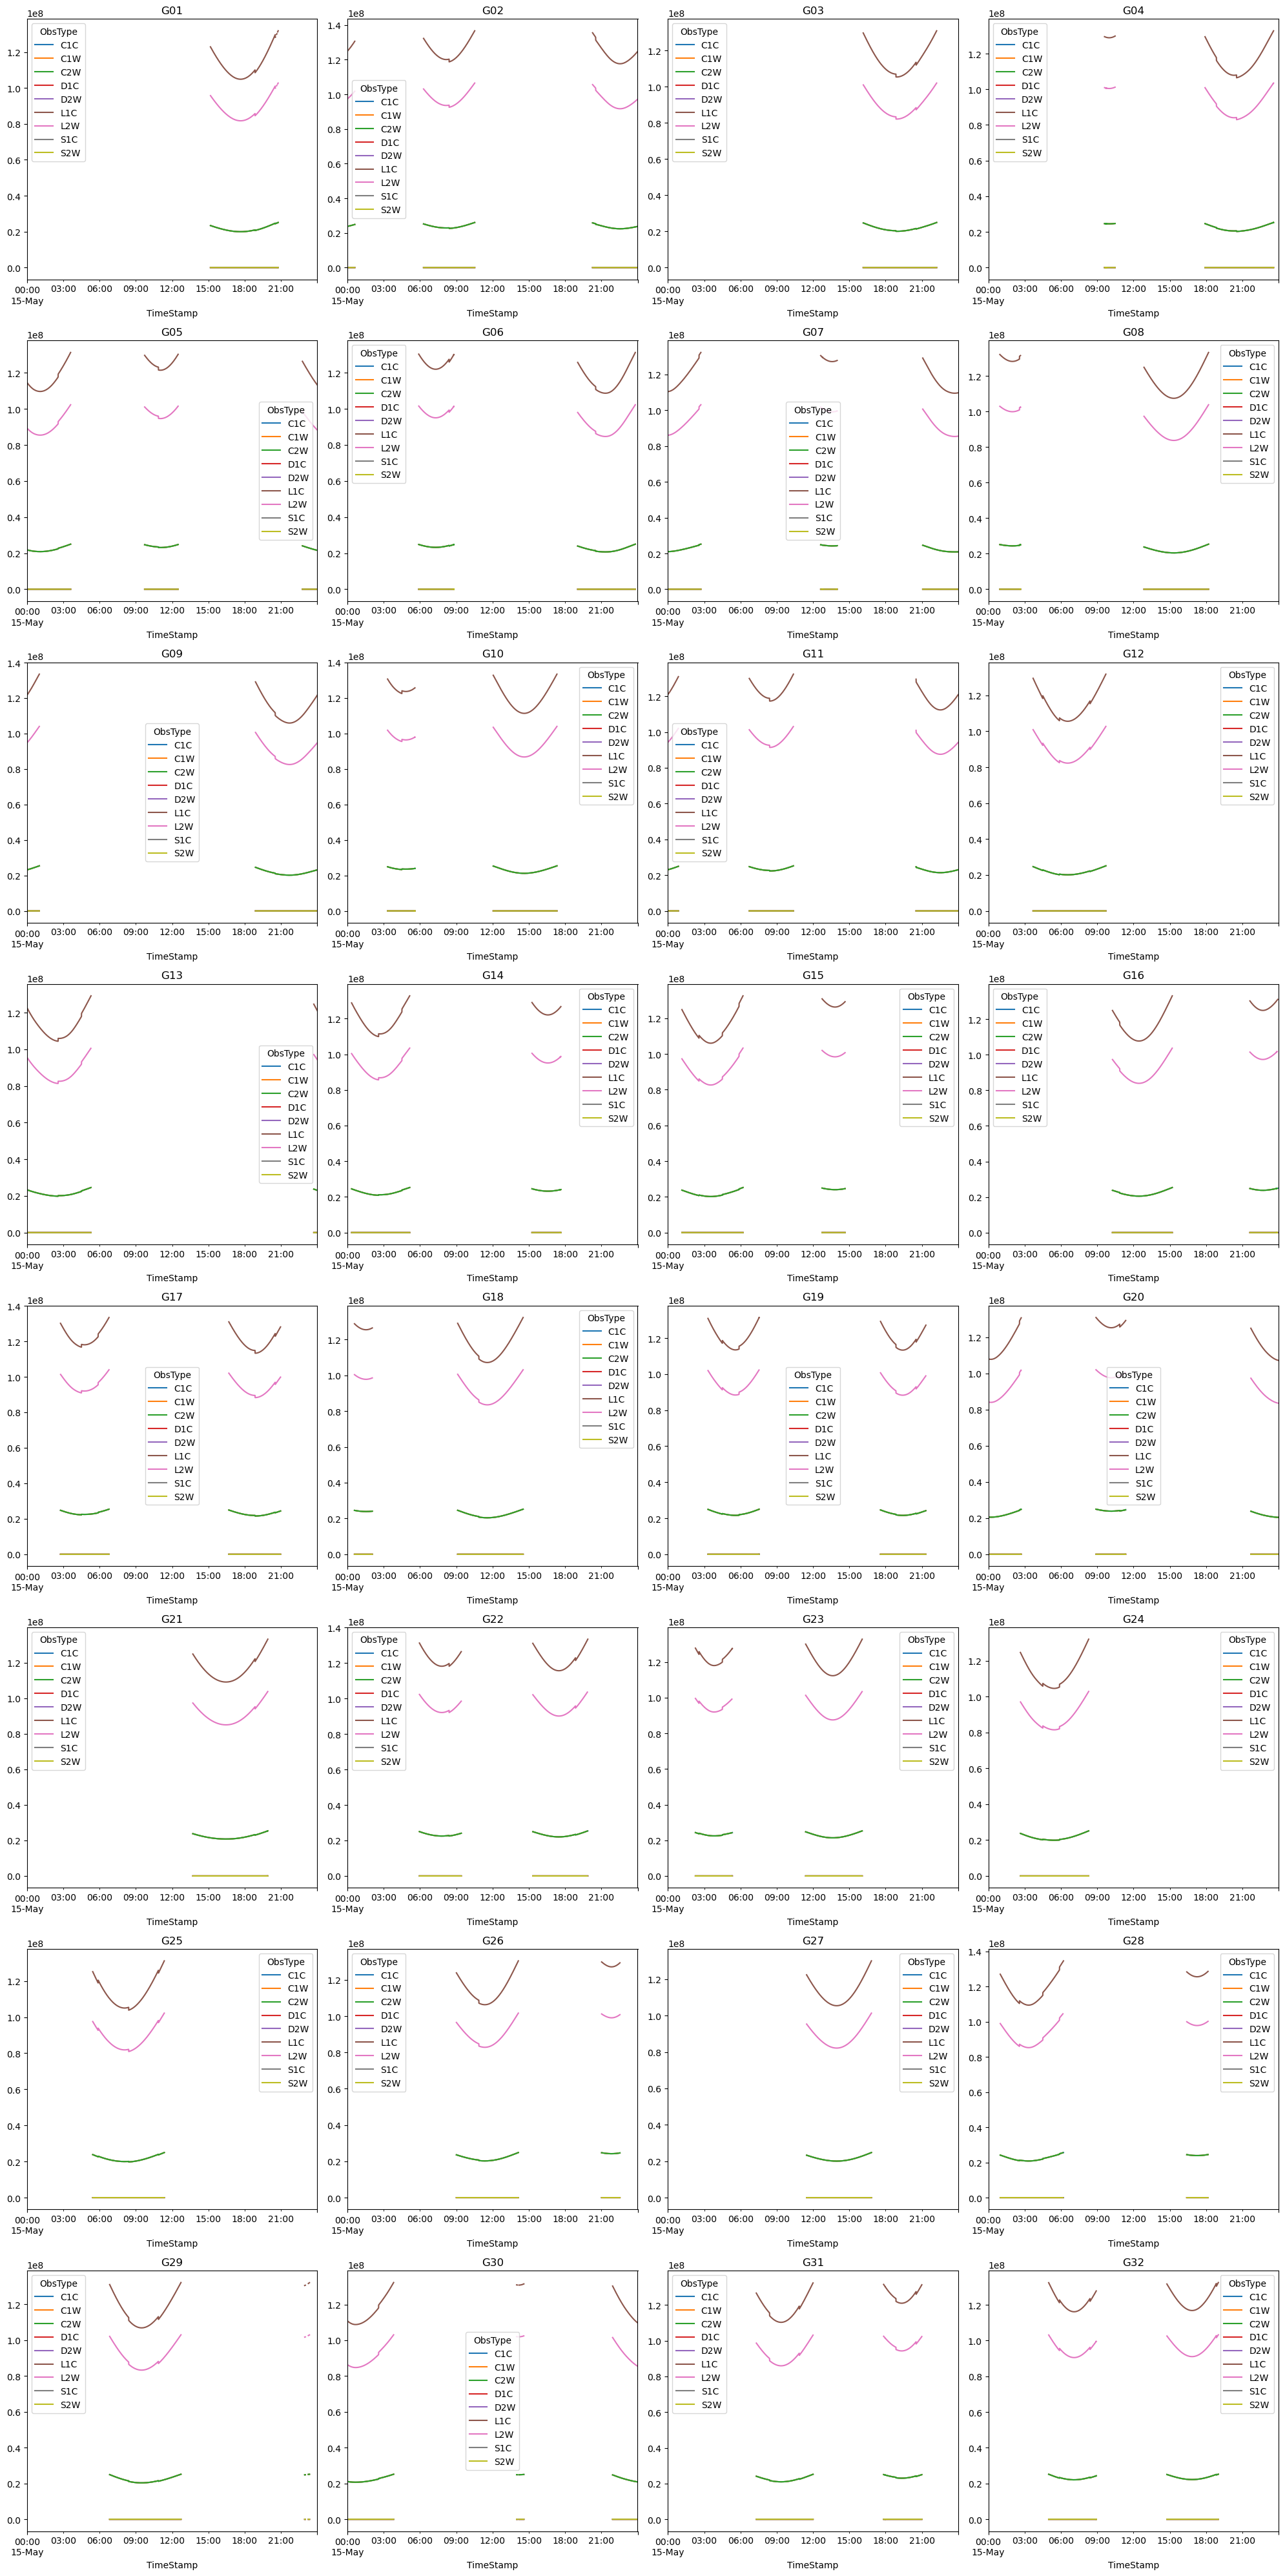

In [127]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

# Plot each satellite's data
for i in range(32):
    satellite = f'G{i+1:02d}'  # Create the satellite name G01, G02, ..., G32
    if satellite in gpsDf_RDN1.columns:
        gpsDf_RDN1[satellite].plot(ax=axes[i])
        axes[i].set_title(satellite)
    else:
        axes[i].set_visible(False)  # Hide the subplot if the satellite data is not available

# Adjust layout
plt.tight_layout()
plt.show()


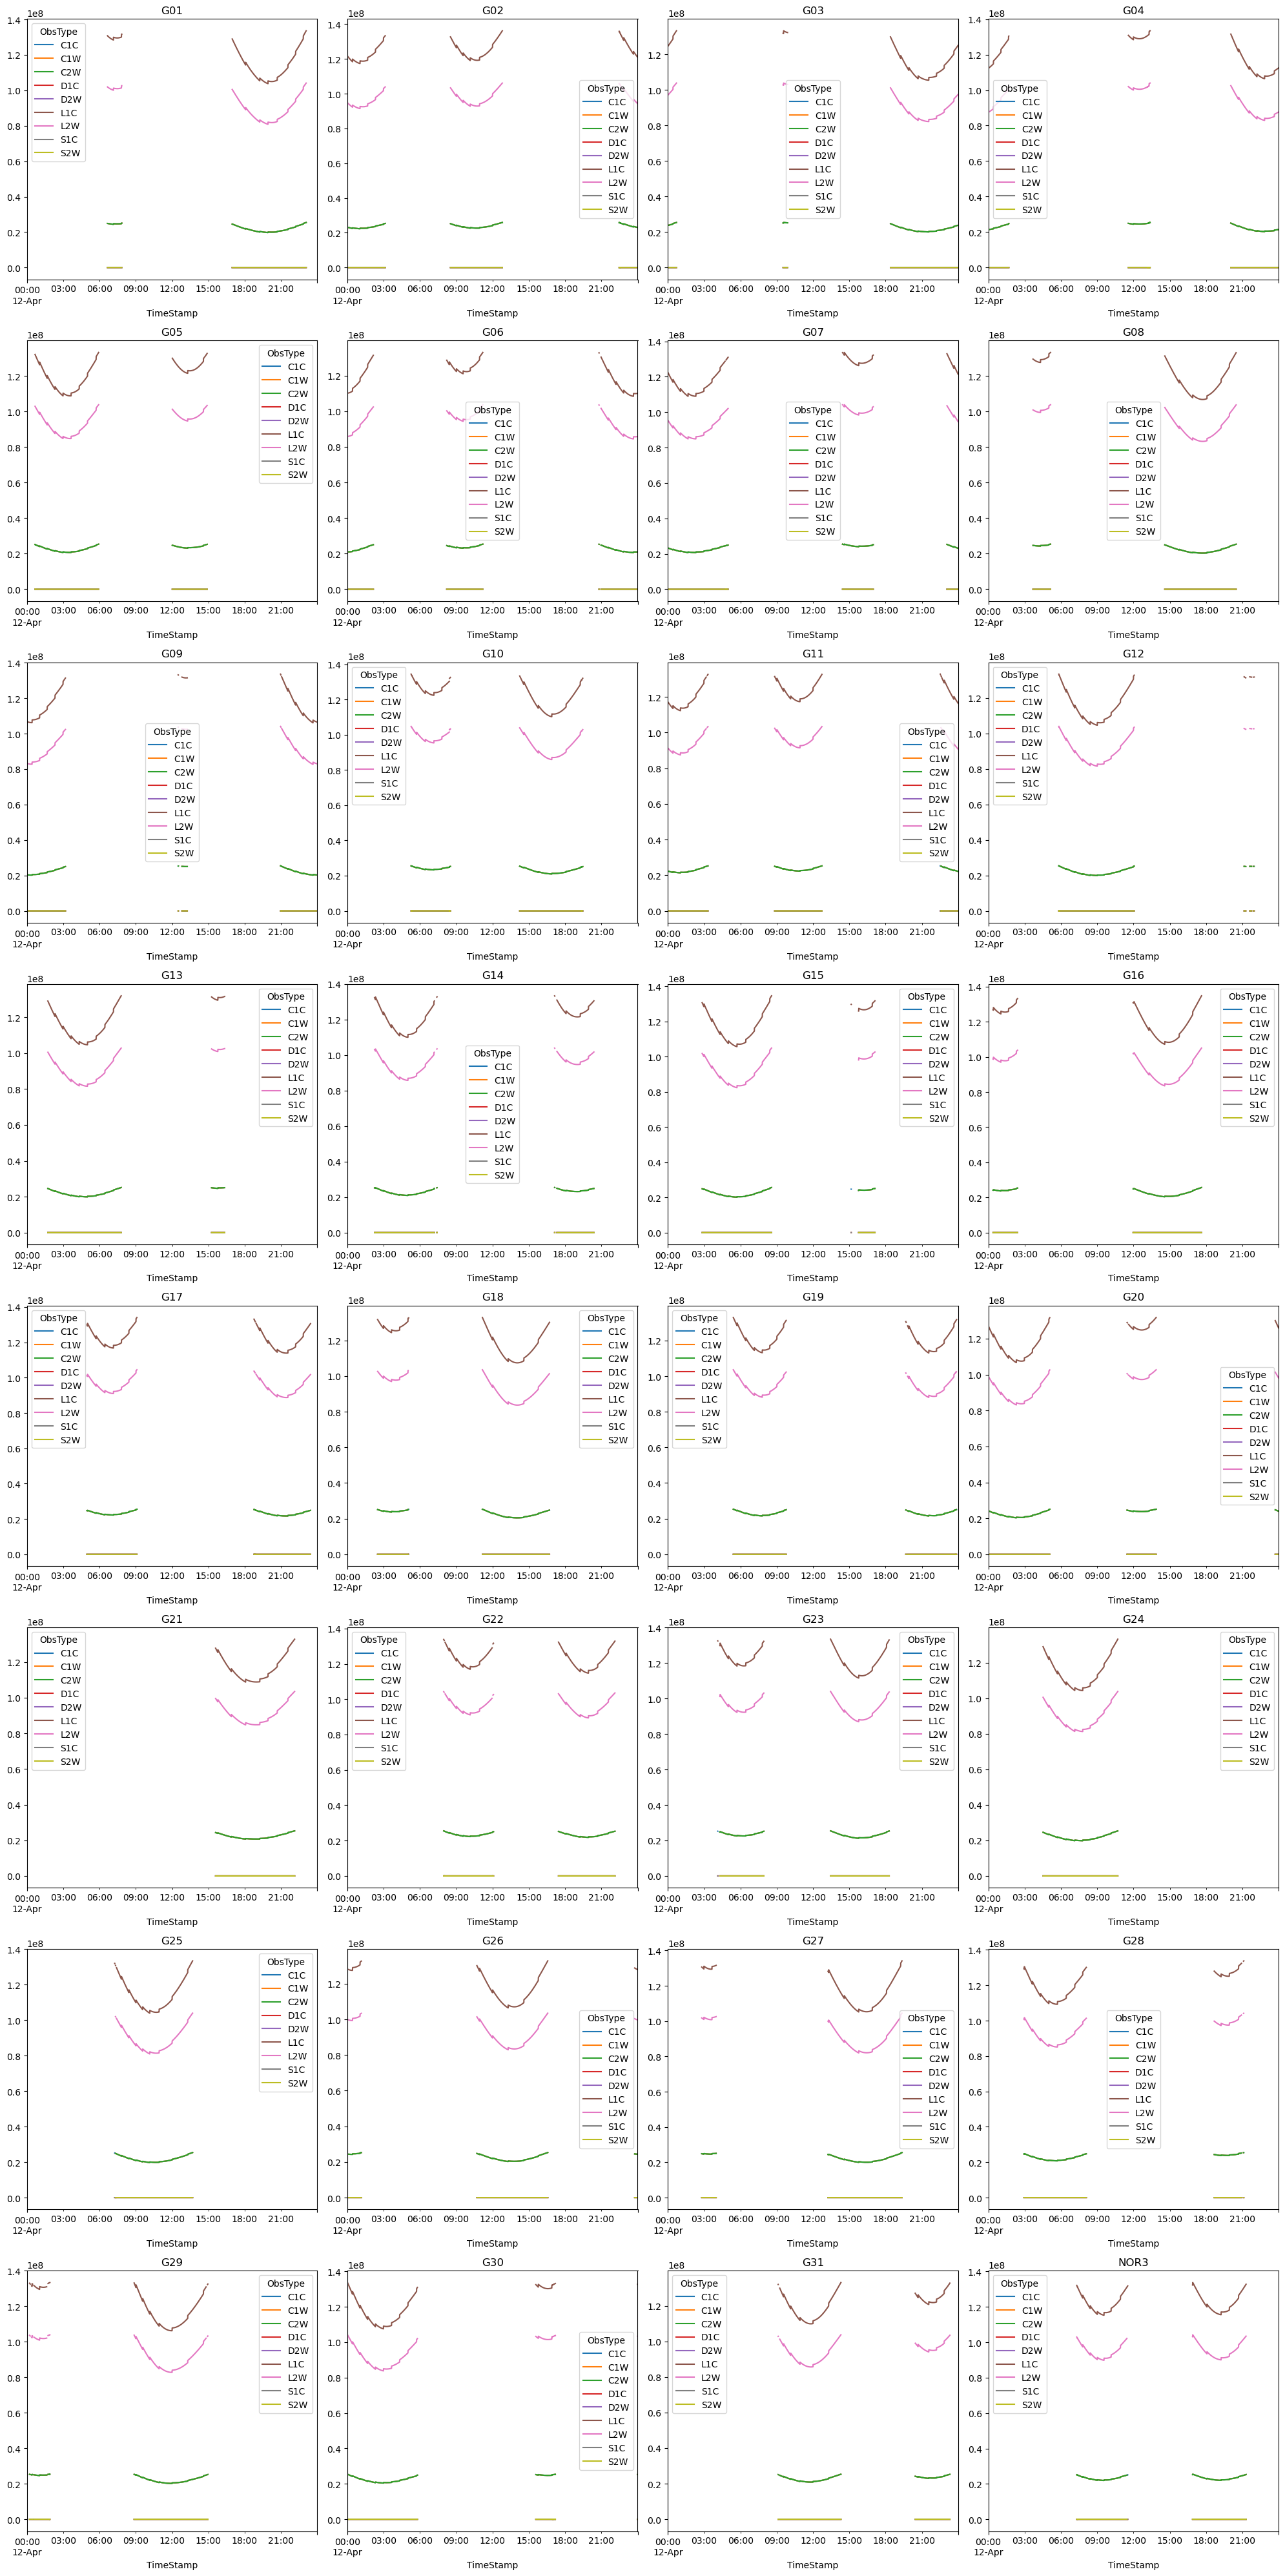

In [269]:

# Create a figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

# Plot each satellite's data
for i in range(32):
    satellite = f'G{i+1:02d}'  # Create the satellite name G01, G02, ..., G32
    if satellite in gpsDf_NOR3.columns:
        gpsDf_NOR3[satellite].plot(ax=axes[i])
        axes[i].set_title(satellite)
    else:
        axes[i].set_visible(False)  # Hide the subplot if the satellite data is not available

# Adjust layout

plt.tight_layout()
plt.show()


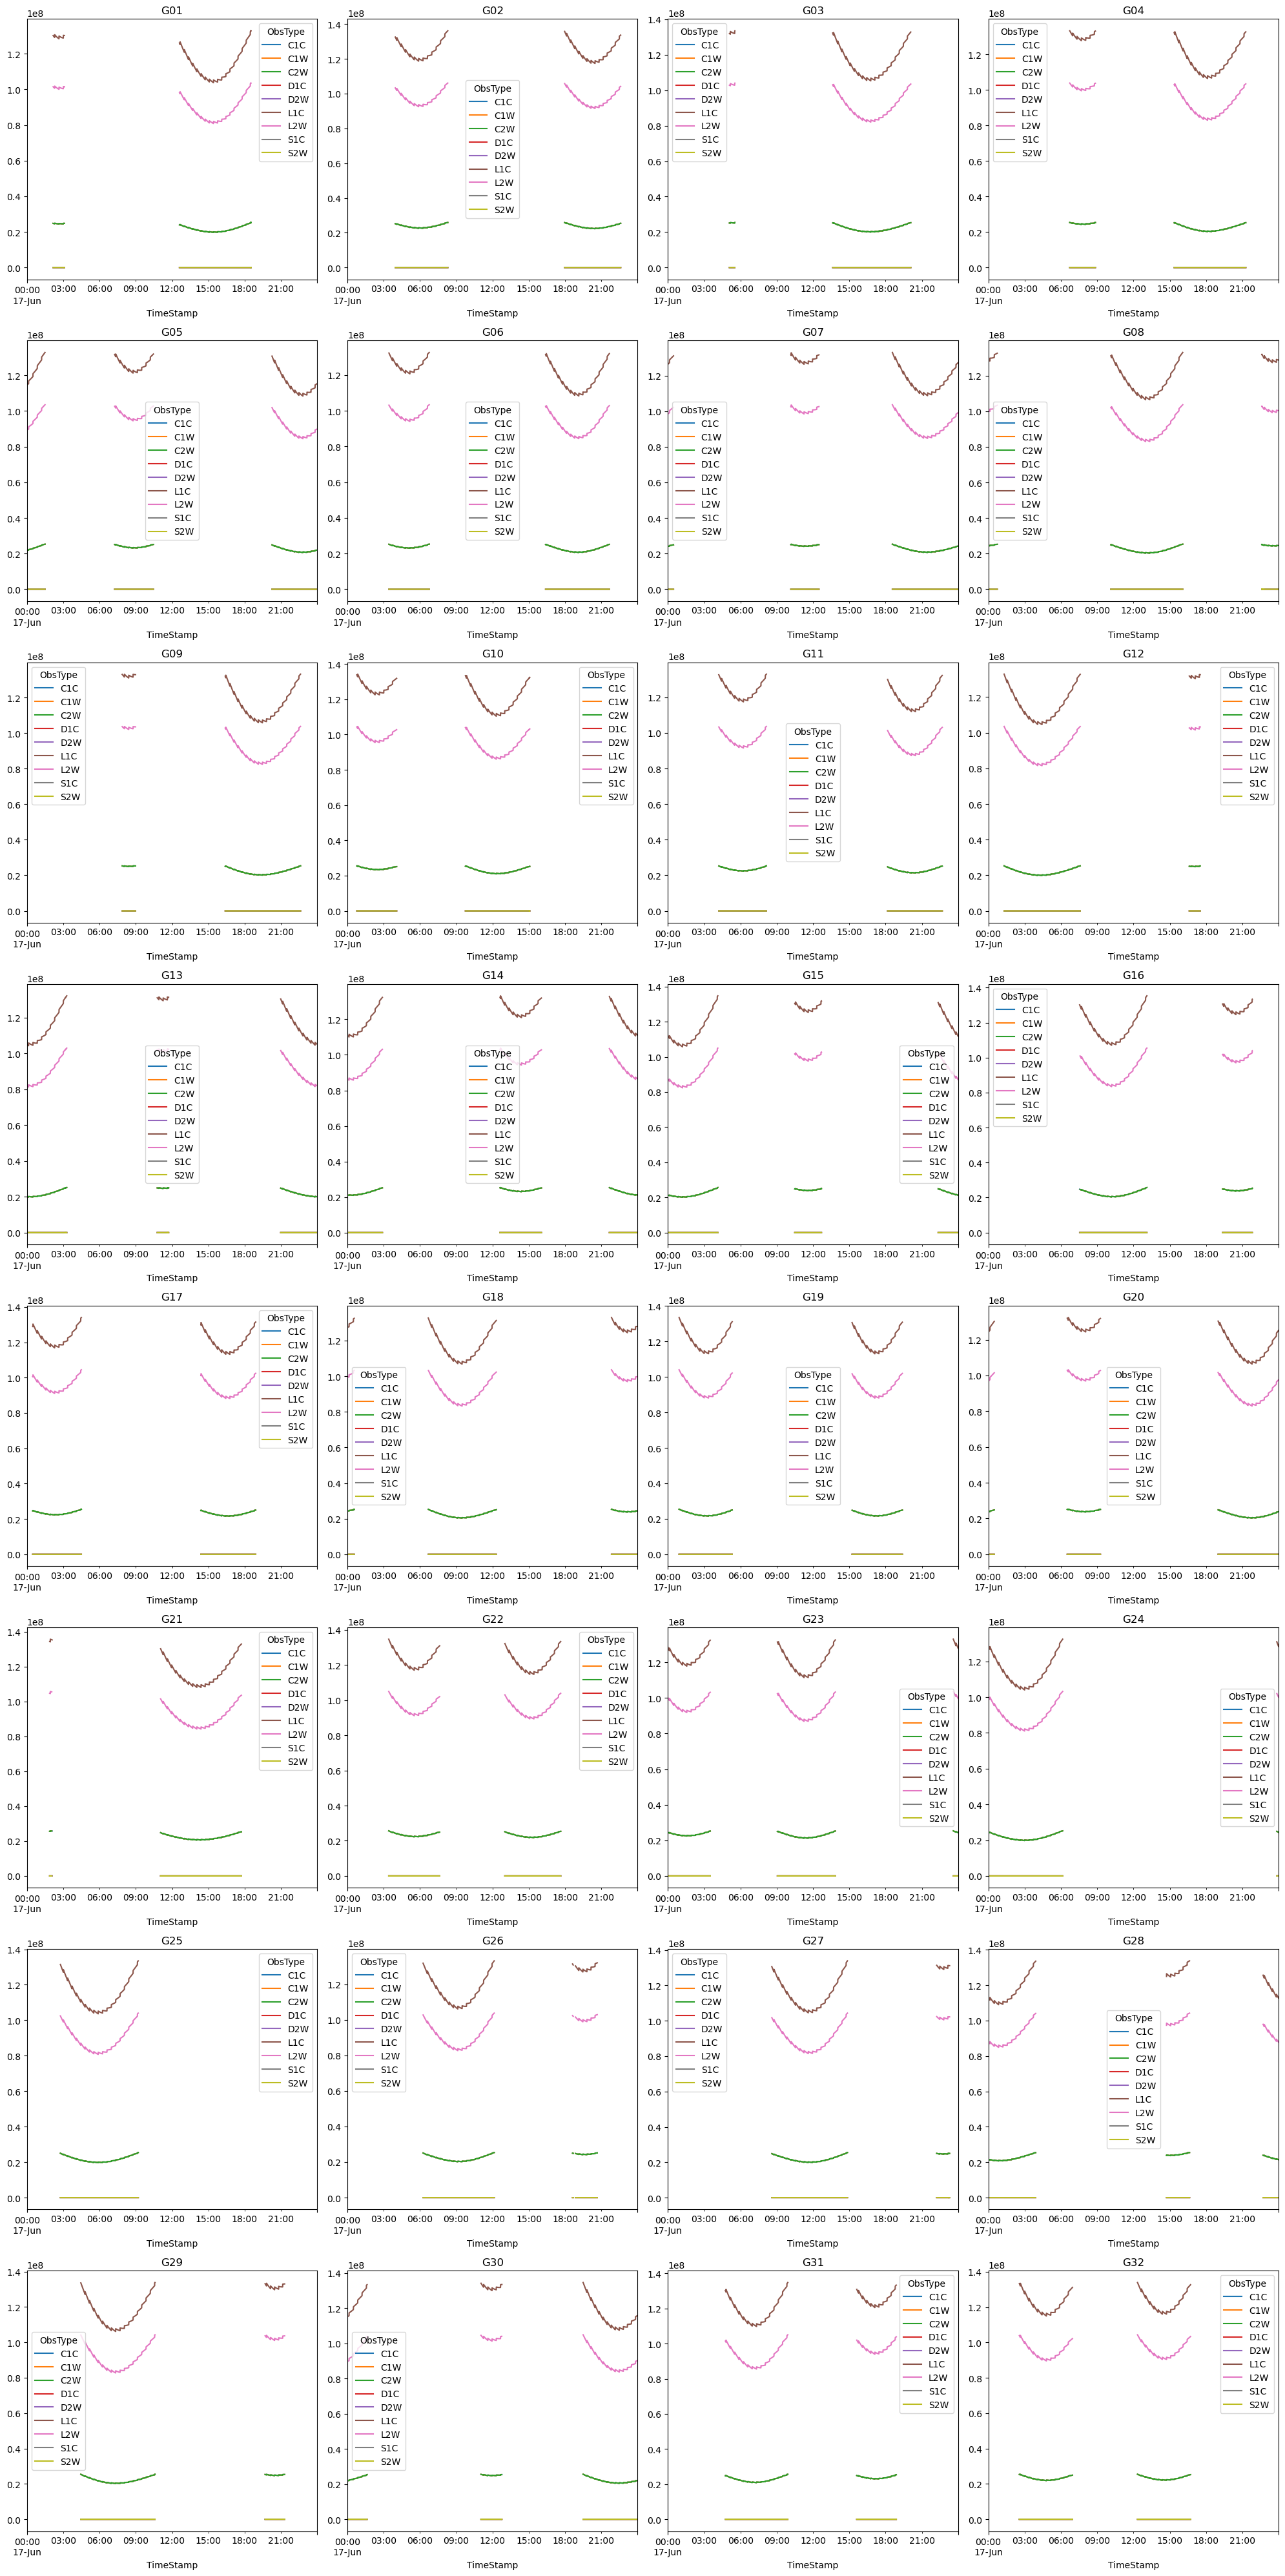

In [311]:

# Create a figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

# Plot each satellite's data
for i in range(32):
    satellite = f'G{i+1:02d}'  # Create the satellite name G01, G02, ..., G32
    if satellite in gpsDf_NORG.columns:
        gpsDf_NORG[satellite].plot(ax=axes[i])
        axes[i].set_title(satellite)
    else:
        axes[i].set_visible(False)  # Hide the subplot if the satellite data is not available

# Adjust layout

plt.tight_layout()
plt.show()


# Part 2: taking differences of observations

Let's repeat two of the plots of the pseudo-range and carrier-phase observations.


In order to see the differences we have two task at hand


* Take differences between signals to actually see what the differences are
* Multiply the carrier-phase with the wavelength of the signal (to obtain units of meters)

We start with taking differences (simple linear combinations) of the pseudo-ranges for which we don't need the frequencies.

In [78]:
LCmat = pd.DataFrame( [ [ -1, 1, 0 ], [ -1, 0, 1], [ 0, -1, 1] ],
            columns=['C1C', 'C2W', 'C1W'],
            index=['C2W-C1C', 'C1W-C1C', 'C1W-C2W'])
LCmat

,C1C,C2W,C1W
C2W-C1C,-1,1,0
C1W-C1C,-1,0,1
C1W-C2W,0,-1,1


The result of the multiplication is now a DataFrame with correct column names.

To put everything together and plot

<AxesSubplot:title={'center':'RDN1 G05'}, xlabel='TimeStamp', ylabel='Pseudo-range differences [m]'>

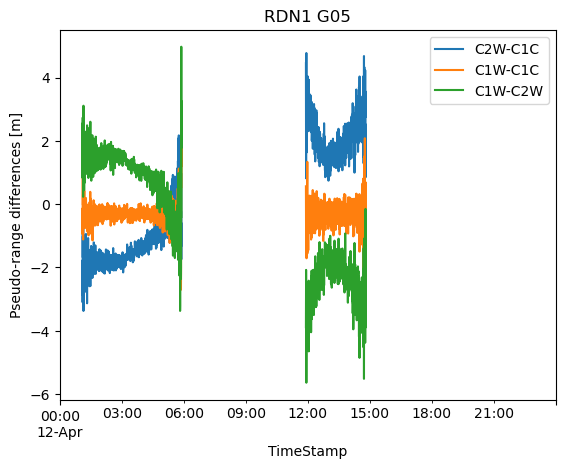

In [79]:
lc = gpsDf_RDN1['G05'][['C1C', 'C2W', 'C1W']] @ LCmat.T
lc.plot(title='RDN1 G05', ylabel='Pseudo-range differences [m]')

<AxesSubplot:title={'center':'NOR3 G05'}, xlabel='TimeStamp', ylabel='Pseudo-range differences [m]'>

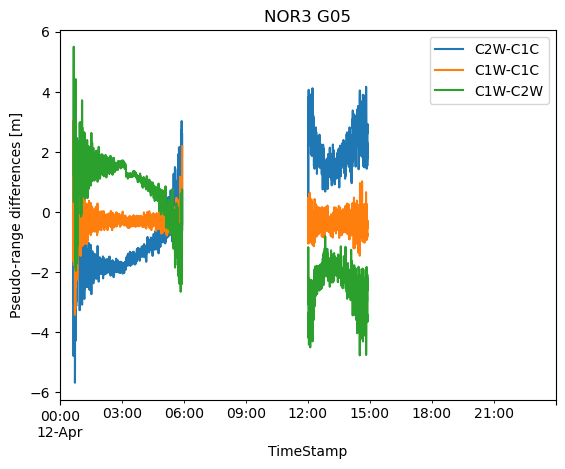

In [80]:
lc = gpsDf_NOR3['G05'][['C1C', 'C2W', 'C1W']] @ LCmat.T
lc.plot(title='NOR3 G05', ylabel='Pseudo-range differences [m]')

<AxesSubplot:title={'center':'NOR3 G05'}, xlabel='TimeStamp', ylabel='Pseudo-range differences [m]'>

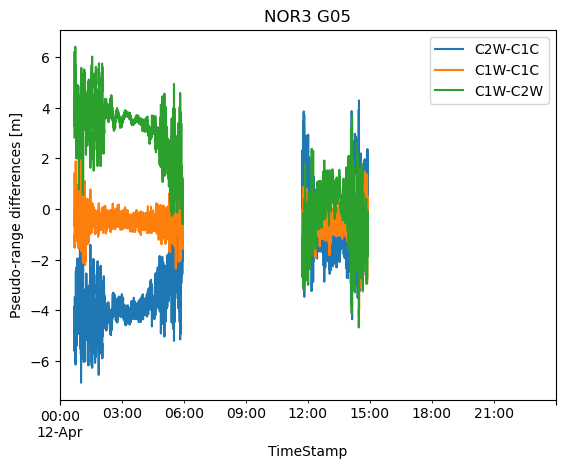

In [81]:
lc = gpsDf_NORG['G05'][['C1C', 'C2W', 'C1W']] @ LCmat.T
lc.plot(title='NOR3 G05', ylabel='Pseudo-range differences [m]')

What you are actually seeing in the `C2X-C2W` is the pseudo-range and multipath error of both measurements, because the range and ionosphere delay are the same for both. The two other combinations, `C2_-C1C`, include also the difference in ionosphere delay between the L1 and L2 frequency (ionosphere delay is dispersive and proportional to the reciprocal of the frequency squared). 

## Ionosphere delay plots

Compute the ionosphere delay using code-phase, code-code, and phase-phase linear combinations, for one of the GPS satellites. 

Plot these in one plot, using three subplots, or using different colors/symbols in the same plot.  The best representation may depend on the data your analysing. 

The following piece of code computes a DataFrame that we can use to compute the ionosphere linear combinations

* `ICL1` single frequency code-phase combination on L1
* `IC12` dual frequency code-code combination using L1 and L2 pseudo-range measurements
* `IL12` dual frequency phase-phase combination using L1 and L2 carrier-phase measurements

In [57]:
sourceTypes = ['C1C', 'L1C', 'C2W', 'L2W']
targetTypes = ['ICL1', 'IC12', 'IL12']

wvl = rnxGetFreqs(['L1' , 'L2'],'G',wavelength=True)
f = rnxGetFreqs(['L1' , 'L2'],'G')

g12 = f['L2']**2 / f['L1']**2
u12 = f['L2']**2 / ( f['L1']**2 - f['L2']**2 )

mmat = [ np.array([  0.5, -0.5*wvl['L1'],   0., 0. ]) , 
         np.array([ -u12,  0.           , u12 , 0. ]) , 
         np.array([  0. ,  u12*wvl['L1'],   0., -u12*wvl['L2'] ]) ]

LCmat = pd.DataFrame(mmat,columns=sourceTypes,index=targetTypes)

#here im only looking at IC12 because this doesnt have the ambiguities that ICL1 and IL12 have 
# sourceTypes = ['C1C', 'L1C', 'C2W', 'L2W']
# targetTypes = ['IC12']

# wvl = rnxGetFreqs(['L1' , 'L2'],'G',wavelength=True)
# f = rnxGetFreqs(['L1' , 'L2'],'G')

# g12 = f['L2']**2 / f['L1']**2
# u12 = f['L2']**2 / ( f['L1']**2 - f['L2']**2 )

# mmat = [  np.array([ -u12,  0.           , u12 , 0. ]) ]

# LCmat = pd.DataFrame(mmat,columns=sourceTypes,index=targetTypes)



In [83]:
LCmat

,C1C,L1C,C2W,L2W
ICL1,0.500000,-0.095147,0.000000,0.000000
IC12,-1.545728,0.000000,1.545728,0.000000
IL12,0.000000,0.294142,0.000000,-0.377483


In [58]:
#RDN1 station
lc_stacked_RDN1 = gpsDf_stacked_RDN1[sourceTypes] @ LCmat.T
lc_stacked_RDN1 

ICL1      IC12       IL12
TimeStamp           SatId                               
2022-05-15 00:00:00 G11   -2.363647  0.794504  -5.112432
                    G07   -6.762946 -3.165650  -5.574471
                    G09   -6.580846  2.822499 -20.364078
                    G02   -3.500552 -2.769944   0.410181
                    G13   -0.801296  0.052555   6.913739
...                             ...       ...        ...
2022-05-15 23:59:45 G02   -3.215468 -1.837870  -4.503087
                    G05   -3.641272 -0.746587  -8.006713
                    G11   -3.313542  1.123744  -3.916273
                    G07   -7.650237 -2.955432  -8.178713
                    G30   -5.129092  3.306312 -12.845867

[53359 rows x 3 columns]

In [59]:
#NOR3 station
lc_stacked_NOR3 = gpsDf_stacked_NOR3[sourceTypes] @ LCmat.T
lc_stacked_NOR3 

ICL1      IC12       IL12
TimeStamp           SatId                               
2022-05-15 00:00:00 G11   -2.933826  1.282954  -8.087622
                    G14   -0.639561  4.439330   1.121211
                    G13   -2.333222 -1.154659  -3.405466
                    G09   -9.420177  2.938429 -14.174071
                    G20   -5.007329 -2.470073  -7.432273
...                             ...       ...        ...
2022-05-15 23:59:45 G20   -6.165094 -1.689480 -12.387216
                    G30   -6.176829  3.091456 -14.108669
                    G16    0.532284  1.827050   1.823373
                    G13   -2.624142  1.218033  -8.281638
                    G07   -7.501571 -3.241391 -16.340914

[57776 rows x 3 columns]

In [60]:
#NORG station
lc_stacked_NORG = gpsDf_stacked_NORG[sourceTypes] @ LCmat.T
lc_stacked_NORG 

ICL1      IC12      IL12
TimeStamp           SatId                              
2022-05-15 00:00:00 G11   -3.289060 -2.157836 -2.396122
                    G05   -4.359695 -5.226106 -2.143831
                    G07   -8.519965 -5.448690 -8.399559
                    G16   -1.398966 -5.428596  3.959218
                    G13   -3.593468 -4.324946 -2.699510
...                             ...       ...       ...
2022-05-15 23:59:45 G20   -6.523033 -5.195191 -6.140199
                    G09   -9.550270 -0.684757 -8.382705
                    G14   -1.816833 -3.805582  4.649168
                    G07   -8.862237 -4.941692 -8.256087
                    G05   -5.770587 -4.068356 -5.463299

[60619 rows x 3 columns]

In [61]:
def rnxUnstack(sysDf: pd.DataFrame) -> pd.DataFrame:
    """
    Function to unstack a pandas RINEX DataFrame. 
    """
    sysDf = sysDf.unstack().reorder_levels([1, 0], axis=1).sort_index(axis=1).dropna(axis=1,how='all')
    
    return sysDf

[End of Notebook - last updated: April 2024]

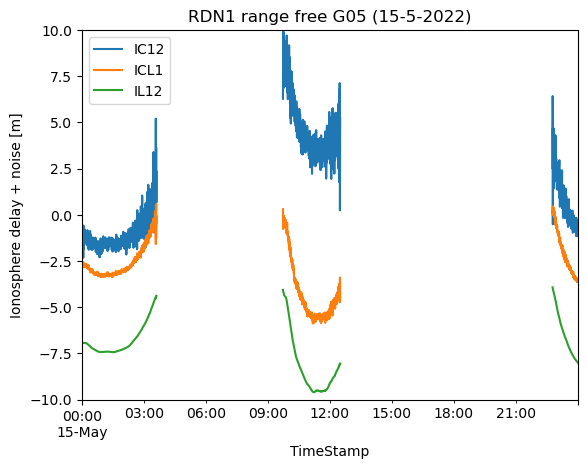

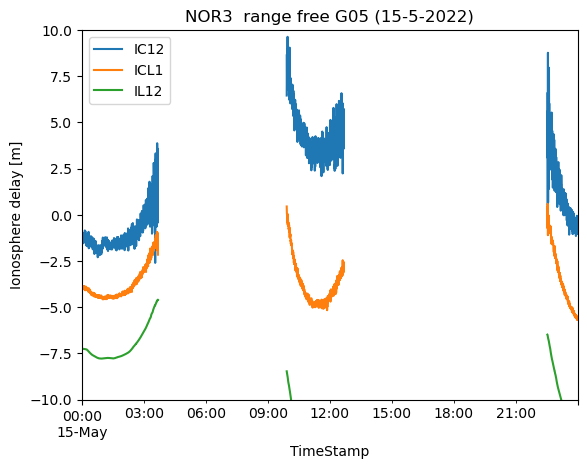

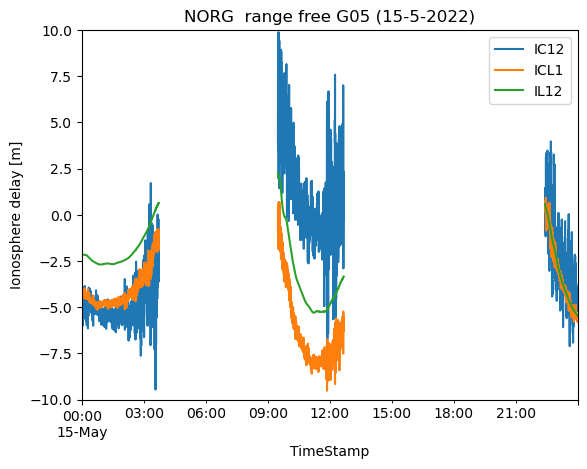

In [62]:
import os
folder = '/Users/isabelslingerland/master AES/year 1/Q4/Lab/figures'

rnxUnstack(lc_stacked_RDN1)['G05'].plot(ylabel='Ionosphere delay + noise [m]', title='RDN1 range free G05 (15-5-2022)')
plt.ylim(-10,10)

filename = 'rdn1_freerange_g05_135.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)
plt.show()

rnxUnstack(lc_stacked_NOR3)['G05'].plot(ylabel='Ionosphere delay [m]', title='NOR3  range free G05 (15-5-2022)');
plt.ylim(-10,10)

filename = 'nor3_freerange_g05_135.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)

rnxUnstack(lc_stacked_NORG)['G05'].plot(ylabel='Ionosphere delay [m]', title='NORG  range free G05 (15-5-2022)');
plt.ylim(-10,10)
filename = 'norg_freerange_g05_135.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)
plt.show()


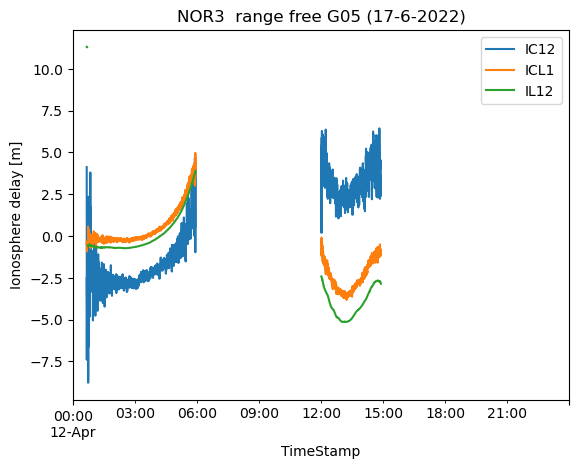

In [89]:
rnxUnstack(lc_stacked_NOR3)['G05'].plot(ylabel='Ionosphere delay [m]', title='NOR3  range free G05 (17-6-2022)');

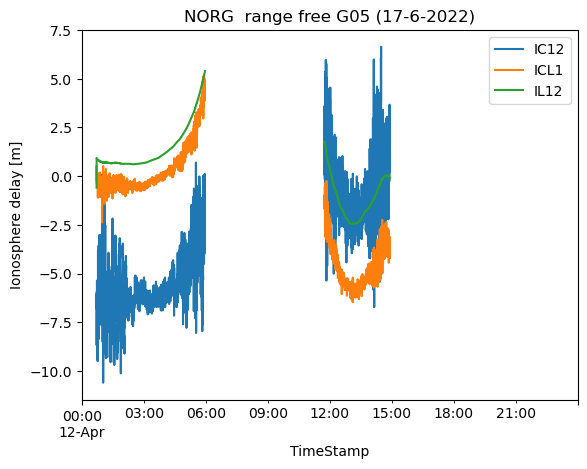

In [90]:
rnxUnstack(lc_stacked_NORG)['G05'].plot(ylabel='Ionosphere delay [m]', title='NORG  range free G05 (17-6-2022)');

## Computing the multipath combination

geometric range and ionosphere delay are eliminated

shows the pseudo range noise and multipath noise

In [63]:
#mulit path combination 
sourceTypes = ['C1C', 'L1C', 'L2W']
targetTypes = ['M12']

wvl = rnxGetFreqs(['L1' , 'L2'],'G',wavelength=True)
f = rnxGetFreqs(['L1' , 'L2'],'G')


a12 = -(f['L1']**2 + f['L2']**2) / (f['L1']**2 - f['L2']**2)
b12 = 2*f['L2']**2 / ( f['L1']**2 - f['L2']**2 )

mmat = [ np.array([  1, a12*wvl['L1'],   b12*wvl['L2'] ]) ]



M12mat = pd.DataFrame(mmat,columns=sourceTypes,index=targetTypes)


# sourceTypes = ['L1C', 'L2W', 'L2X', 'L5X']
# targetTypes = ['L2W[m]-L1C[m]', 'L2X[m]-L1C[m]', 'L5X[m]-L1C[m]', 'L2X[m]-L2W[m]']

# wvl = np.array( list( rnxGetFreqs(sourceTypes,'G',wavelength=True).values() ) )

# mmat = [ np.array([ -1., 1., 0., 0. ]) * wvl, 
#          np.array([ -1., 0., 1., 0. ]) * wvl, 
#          np.array([ -1., 0., 0., 1. ]) * wvl, 
#          np.array([ 0., -1., 1., 0. ]) * wvl ]

# other = pd.DataFrame(mmat,columns=sourceTypes,index=targetTypes)
# print(other)

In [64]:
#RDN1 station
M12_stacked_RDN1 = gpsDf_stacked_RDN1[sourceTypes] @ M12mat.T
M12_stacked_RDN1 


M12
TimeStamp           SatId           
2022-05-15 00:00:00 G11     5.497570
                    G07    -2.376951
                    G09    27.566465
                    G02    -7.821467
                    G13   -15.430070
...                              ...
2022-05-15 23:59:45 G02     2.575237
                    G05     8.730883
                    G11     1.205463
                    G07     1.056952
                    G30    15.433550

[53359 rows x 1 columns]

In [65]:
#NOR3 station
M12_stacked_NOR3 = gpsDf_stacked_NOR3[sourceTypes] @ M12mat.T
M12_stacked_NOR3

M12
TimeStamp           SatId           
2022-05-15 00:00:00 G11    10.307591
                    G14    -3.521544
                    G13     2.144487
                    G09     9.507789
                    G20     4.849887
...                              ...
2022-05-15 23:59:45 G20    12.444243
                    G30    15.863679
                    G16    -2.582178
                    G13    11.314991
                    G07    17.678687

[57776 rows x 1 columns]

In [66]:
#NORG station
M12_stacked_NORG = gpsDf_stacked_NORG[sourceTypes] @ M12mat.T
M12_stacked_NORG

M12
TimeStamp           SatId           
2022-05-15 00:00:00 G11    -1.785876
                    G05    -4.431729
                    G07    -0.240811
                    G16   -10.716367
                    G13    -1.787916
...                              ...
2022-05-15 23:59:45 G20    -0.765668
                    G09    -2.335129
                    G14   -12.932002
                    G07    -1.212301
                    G05    -0.614574

[60619 rows x 1 columns]

In [67]:
rnxUnstack(M12_stacked_RDN1)['G05']


,M12
TimeStamp,
2022-05-15 00:00:00,8.449632
2022-05-15 00:00:15,8.394584
2022-05-15 00:00:30,8.374635
2022-05-15 00:00:45,8.415402
2022-05-15 00:01:00,8.531283
...,...
2022-05-15 23:58:45,8.854908
2022-05-15 23:59:00,8.816767
2022-05-15 23:59:15,8.908619


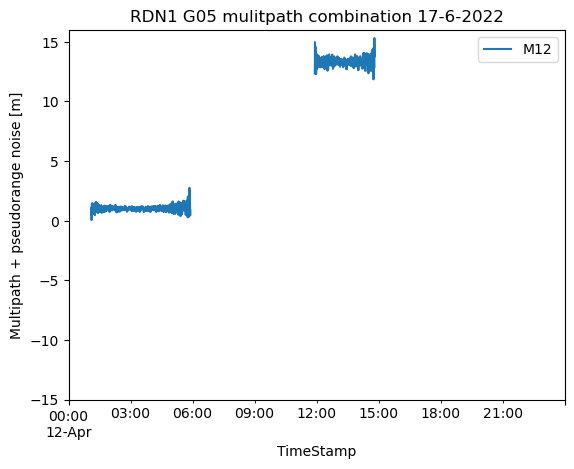

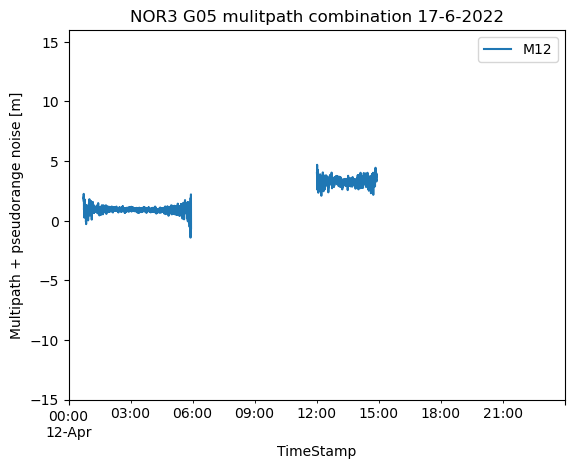

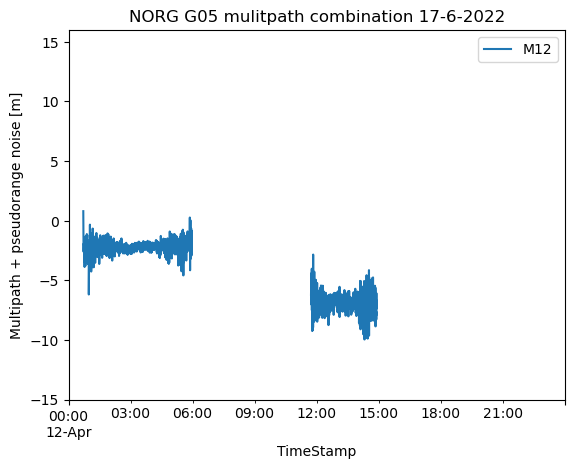

In [34]:
rnxUnstack(M12_stacked_RDN1)['G05'].plot(ylabel='Multipath + pseudorange noise [m]', title='RDN1 G05 mulitpath combination 15-6-2022')
plt.ylim(-15,16)
filename = 'rdn1_mult_g05_102.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)
plt.show()
rnxUnstack(M12_stacked_NOR3)['G05'].plot(ylabel='Multipath + pseudorange noise [m]', title='NOR3 G05 mulitpath combination 17-6-2022')
plt.ylim(-15,16)
filename = 'nor3_multi_g05_102.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)
plt.show()
rnxUnstack(M12_stacked_NORG)['G05'].plot(ylabel='Multipath + pseudorange noise [m]', title='NORG G05 mulitpath combination 17-6-2022')
plt.ylim(-15,16)
filename = 'norg_multi_g05_102.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)
plt.show()

                           M12
TimeStamp                     
2022-04-12 01:05:45   0.534314
2022-04-12 01:06:00   0.706563
2022-04-12 01:06:15   1.125949
2022-04-12 01:06:30   0.049967
2022-04-12 01:06:45   0.095898
...                        ...
2022-04-12 14:47:15  14.368076
2022-04-12 14:47:30  15.316881
2022-04-12 14:47:45  14.492010
2022-04-12 14:48:00  13.748460
2022-04-12 14:48:15  14.086866

[1846 rows x 1 columns]


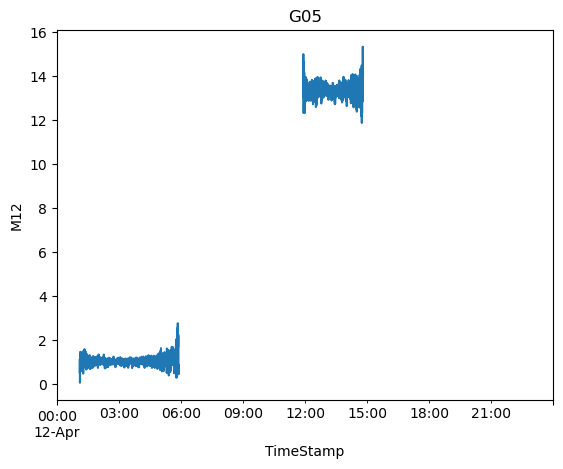

In [35]:
#RDN1 station
satId='G05'
item='M12'
M12_RDN1 = gpsDf_RDN1[satId][sourceTypes] @ M12mat.T
M12_RDN1 



print(M12_RDN1.dropna(how='all'))

M12_RDN1[item].plot(title=satId, ylabel=item);




                           M12
TimeStamp                     
2022-04-12 00:39:45 -23.598902
2022-04-12 00:40:00 -23.285544
2022-04-12 00:40:15 -23.681543
2022-04-12 00:40:30 -24.445434
2022-04-12 00:40:45 -24.198079
...                        ...
2022-04-12 14:52:45   4.003146
2022-04-12 14:53:00   3.636710
2022-04-12 14:53:15   3.901240
2022-04-12 14:53:30   3.291116
2022-04-12 14:53:45   3.450262

[1946 rows x 1 columns]


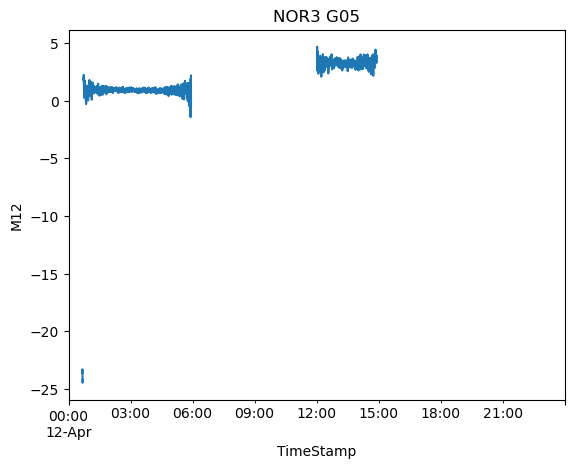

In [36]:
M12_NOR3 = gpsDf_NOR3[satId][sourceTypes] @ M12mat.T
M12_NOR3 



print(M12_NOR3.dropna(how='all'))

M12_NOR3[item].plot(title='NOR3 G05', ylabel=item);


                          M12
TimeStamp                    
2022-04-12 00:42:30  0.797863
2022-04-12 00:42:45 -0.807645
2022-04-12 00:43:00 -2.489486
2022-04-12 00:43:15 -2.602647
2022-04-12 00:43:30 -2.212532
...                       ...
2022-04-12 14:52:45 -7.614959
2022-04-12 14:53:00 -8.286592
2022-04-12 14:53:15 -6.077837
2022-04-12 14:53:30 -7.387230
2022-04-12 14:53:45 -7.072086

[2022 rows x 1 columns]


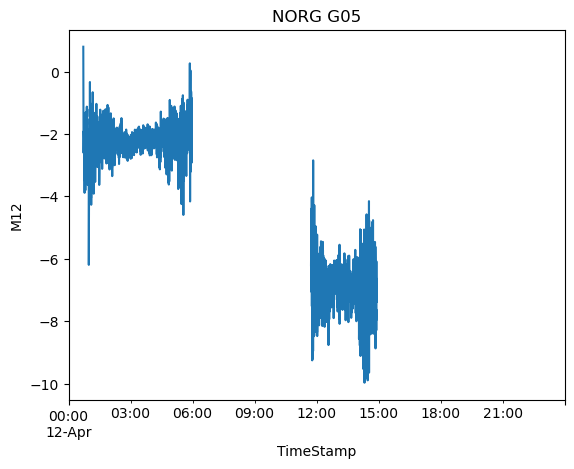

In [37]:
M12_NORG = gpsDf_NORG[satId][sourceTypes] @ M12mat.T
M12_NORG 



print(M12_NORG.dropna(how='all'))

M12_NORG[item].plot(title='NORG G05', ylabel=item);


               M12
count  1844.000000
mean      0.001127
std       0.319194
min      -1.916200
25%      -0.147666
50%      -0.004719
75%       0.152071
max       2.305575
               M12
count  1943.000000
mean     -0.001787
std       0.318533
min      -2.837909
25%      -0.149868
50%       0.006393
75%       0.148489
max       2.247052
               M12
count  2020.000000
mean     -0.001254
std       0.893902
min      -5.658152
25%      -0.415755
50%      -0.007159
75%       0.399940
max       6.111020


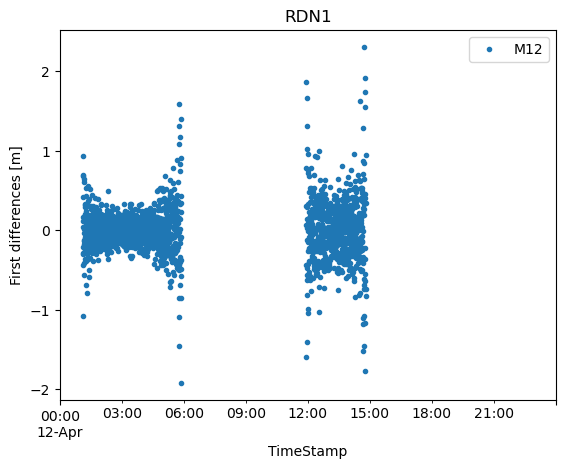

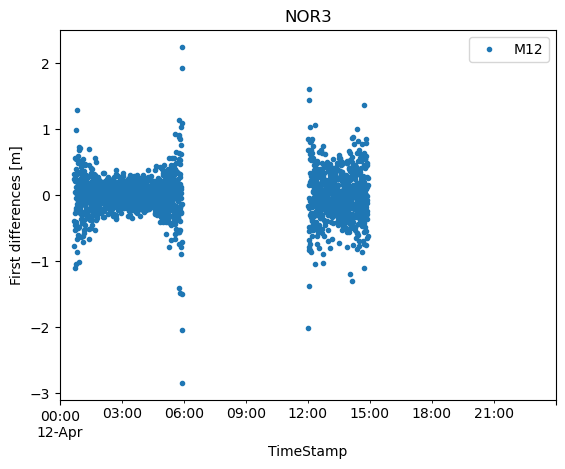

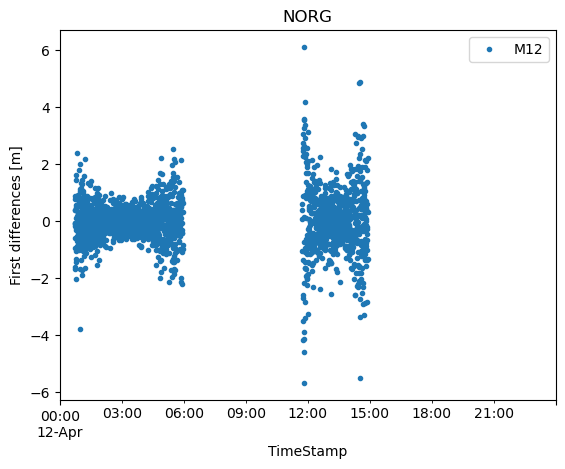

In [38]:
M12_RDN1diff = M12_RDN1.diff()
print(M12_RDN1diff.describe())

M12_RDN1diff.plot(style='.',title='RDN1', ylabel='First differences [m]');

M12_NOR3diff = M12_NOR3.diff()
print(M12_NOR3diff.describe())

M12_NOR3diff.plot(style='.',title='NOR3', ylabel='First differences [m]');

M12_NORGdiff = M12_NORG.diff()
print(M12_NORGdiff.describe())

M12_NORGdiff.plot(style='.',title='NORG', ylabel='First differences [m]');

In [39]:
def rnxSegmentSat(lcsat: pd.DataFrame, crit: float = 1., gap: float=45., verbose: int = 0):
    
    # drop rows with all NaN and compute the first differences (pandas returns the same shape)
    lcdiff = lcsat.dropna(axis=0,how='all').diff()
    t=lcdiff.index.values

    # test for gaps, add start of the series to the bool
    b1 = np.diff(t, prepend=t[0]) > pd.Timedelta(gap,'sec') 
    b1[0]=True
    
    # test for steps
    b2 = lcdiff.abs() > crit
    b2 = b2.any(axis=1)

    # combine the two and get index to t, and add a refererence to the last+1 element in t 
    ipos= np.where( b1 | b2 )
    if verbose > 1: 
        print(t[ipos])
    ipos=np.append(ipos,len(t))
    if verbose > 1: 
        print(ipos)
    
    segments=np.empty([0,3])
    if verbose > 0: print('Start time                    End time                      Count')
    for k in range(len(ipos)-1):
        tstart = t[ipos[k]]
        tend = t[ipos[k+1]-1]
        numdata = ipos[k+1]-ipos[k]
        if verbose > 0: print(tstart,tend,numdata)
        segments=np.vstack([segments,[tstart, tend, numdata ]])
    
    return segments 



In [42]:
segmentsRDN1=rnxSegmentSat(M12_RDN1, crit=2.2, gap=45., verbose=1)
segmentsNOR3=rnxSegmentSat(M12_NOR3, crit=2.8, gap=45., verbose=1)
segmentsNORG=rnxSegmentSat(M12_NORG, crit=5.7, gap=45., verbose=1)

Start time                    End time                      Count
2022-04-12T01:05:45.000000000 2022-04-12T05:53:00.000000000 1150
2022-04-12T11:54:30.000000000 2022-04-12T14:44:00.000000000 679
2022-04-12T14:44:15.000000000 2022-04-12T14:48:15.000000000 17
Start time                    End time                      Count
2022-04-12T00:39:45.000000000 2022-04-12T00:40:45.000000000 5
2022-04-12T00:43:30.000000000 2022-04-12T05:55:00.000000000 1247
2022-04-12T05:55:15.000000000 2022-04-12T05:55:15.000000000 1
2022-04-12T12:00:45.000000000 2022-04-12T14:53:45.000000000 693
Start time                    End time                      Count
2022-04-12T00:42:30.000000000 2022-04-12T05:57:15.000000000 1260
2022-04-12T11:43:30.000000000 2022-04-12T11:49:30.000000000 25
2022-04-12T11:49:45.000000000 2022-04-12T14:53:45.000000000 737


In [43]:
def rnxRemoveOffset(lcsat: pd.DataFrame, segments: np.ndarray, item : str, verbose: int = 0) -> pd.DataFrame:
    
    if verbose > 0: print('Start time                    End time                      Count  Mean')

    for segment in segments:
        tstart = segment[0]
        tend = segment[1]
        tmp = lcsat.loc[tstart:tend,item]  
        if verbose > 0: print(tstart, tend, len(tmp), tmp.mean())
        tmp = tmp - tmp.mean()
        lcsat.loc[tstart:tend,item] = tmp


    return lcsat

In [44]:
rnxRemoveOffset(M12_RDN1,segmentsRDN1,item, verbose=1)
rnxRemoveOffset(M12_NOR3,segmentsNOR3,item, verbose=1)
rnxRemoveOffset(M12_NORG,segmentsNORG,item, verbose=1)

Start time                    End time                      Count  Mean
2022-04-12T01:05:45.000000000 2022-04-12T05:53:00.000000000 1150 1.031816384649795
2022-04-12T11:54:30.000000000 2022-04-12T14:44:00.000000000 679 13.335460936219949
2022-04-12T14:44:15.000000000 2022-04-12T14:48:15.000000000 17 13.6706481172758
Start time                    End time                      Count  Mean
2022-04-12T00:39:45.000000000 2022-04-12T00:40:45.000000000 5 -23.841900327801703
2022-04-12T00:43:30.000000000 2022-04-12T05:55:00.000000000 1247 0.912900460954179
2022-04-12T05:55:15.000000000 2022-04-12T05:55:15.000000000 1 -0.6322779208421707
2022-04-12T12:00:45.000000000 2022-04-12T14:53:45.000000000 693 3.2781478742629417
Start time                    End time                      Count  Mean
2022-04-12T00:42:30.000000000 2022-04-12T05:57:15.000000000 1260 -2.1961683796866547
2022-04-12T11:43:30.000000000 2022-04-12T11:49:30.000000000 25 -6.543869620561599
2022-04-12T11:49:45.000000000 2022-04-12T

,M12
TimeStamp,
2022-04-12 00:00:00,NaN
2022-04-12 00:00:15,NaN
2022-04-12 00:00:30,NaN
2022-04-12 00:00:45,NaN
2022-04-12 00:01:00,NaN
...,...
2022-04-12 23:58:45,NaN
2022-04-12 23:59:00,NaN
2022-04-12 23:59:15,NaN


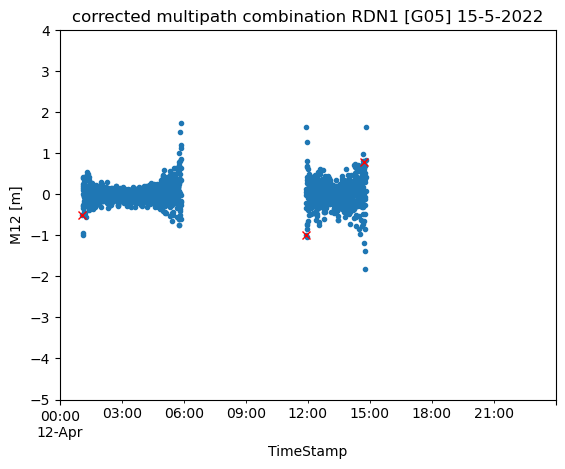

In [45]:
M12_RDN1[item].plot(style='.',title='corrected multipath combination RDN1 [G05] 15-5-2022', ylabel='M12 [m]')
M12_RDN1.loc[segmentsRDN1[:,0]][item].plot(style='x',color='red')
plt.ylim(-5,4)
filename = 'rdn1_multicorrected_g05_102.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)
plt.show()



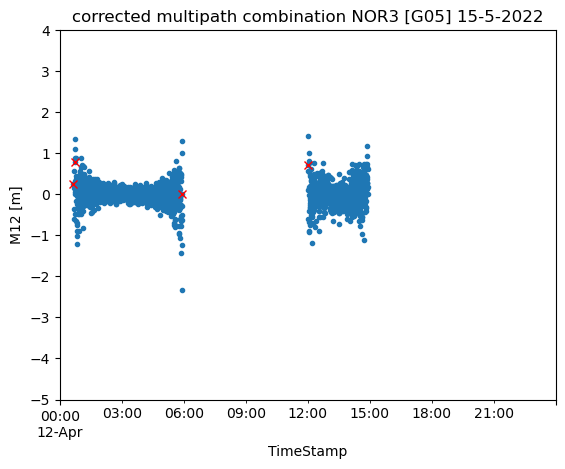

In [46]:
M12_NOR3[item].plot(style='.',title='corrected multipath combination NOR3 [G05] 15-5-2022', ylabel='M12 [m]')
M12_NOR3.loc[segmentsNOR3[:,0]][item].plot(style='x',color='red')
plt.ylim(-5,4)
filename = 'nor3_multicorrected_g05_102.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)
plt.show()

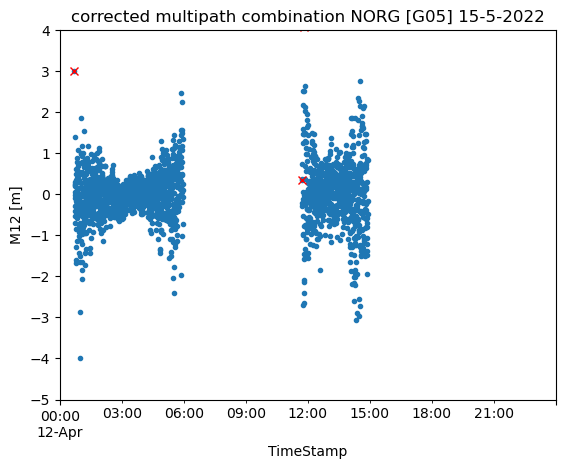

In [47]:
M12_NORG[item].plot(style='.',title='corrected multipath combination NORG [G05] 15-5-2022', ylabel='M12 [m]')
M12_NORG.loc[segmentsNORG[:,0]][item].plot(style='x',color='red')
plt.ylim(-5,4)
filename = 'norg_multicorrected_g05_102.png'

# Combine the folder and filename to create the full path
save_path = os.path.join(folder, filename)

# Step 4: Save the plot to the specified path
plt.savefig(save_path)
plt.show()

## Ionosphere Free linear combination
ionosphere delay is eliminated. but geometri range + pseudo range and multipath noise is there

In [289]:
sourceTypes = ['C1C', 'L1C', 'C2W', 'L2W']
targetTypes = ['GCL1', 'GC12', 'GL12']

wvl = rnxGetFreqs(['L1' , 'L2'],'G',wavelength=True)
f = rnxGetFreqs(['L1' , 'L2'],'G')

g12 = f['L2']**2 / f['L1']**2
u12 = f['L2']**2 / ( f['L1']**2 - f['L2']**2 )

mmat = [ np.array([  0.5, 0.5*wvl['L1'],   0., 0. ]) , 
         np.array([ u12+1,  0.      , -u12 , 0. ]) , 
         np.array([  0. ,  (u12+1)*wvl['L1'],   0., -u12*wvl['L2'] ]) ]

Gmat = pd.DataFrame(mmat,columns=sourceTypes,index=targetTypes)

In [290]:
#RDN1 station
G_stacked_RDN1 = gpsDf_stacked_RDN1[sourceTypes] @ Gmat.T
G_stacked_RDN1 

GCL1          GC12          GL12
TimeStamp           SatId                                          
2022-04-12 00:00:00 G06    2.100462e+07  2.100461e+07  2.100462e+07
                    G09    2.036809e+07  2.036808e+07  2.036808e+07
                    G16    2.491800e+07  2.491800e+07  2.491800e+07
                    G03    2.375546e+07  2.375545e+07  2.375545e+07
                    G02    2.320800e+07  2.320800e+07  2.320800e+07
...                                 ...           ...           ...
2022-04-12 23:59:45 G02    2.293158e+07  2.293159e+07  2.293158e+07
                    G11    2.206054e+07  2.206054e+07  2.206054e+07
                    G04    2.131570e+07  2.131570e+07  2.131570e+07
                    G16    2.461766e+07  2.461766e+07  2.461766e+07
                    G07    2.302015e+07  2.302015e+07  2.302015e+07

[54166 rows x 3 columns]

In [291]:
#NOR3 station
G_stacked_NOR3 = gpsDf_stacked_NOR3[sourceTypes] @ Gmat.T
G_stacked_NOR3

GCL1          GC12          GL12
TimeStamp           SatId                                          
2022-04-12 00:00:00 G02    2.315360e+07  2.315360e+07  2.315360e+07
                    G11    2.229184e+07  2.229184e+07  2.229184e+07
                    G20    2.418355e+07  2.418355e+07  2.418355e+07
                    G09    2.031442e+07  2.031441e+07  2.031441e+07
                    G26    2.440173e+07  2.440173e+07  2.440173e+07
...                                 ...           ...           ...
2022-04-12 23:59:45 G20    2.397278e+07  2.397278e+07  2.397278e+07
                    G30    2.523914e+07  2.523914e+07  2.523914e+07
                    G04    2.140749e+07  2.140749e+07  2.140749e+07
                    G06    2.094175e+07  2.094174e+07  2.094175e+07
                    G26    2.433963e+07  2.433962e+07  2.433963e+07

[58698 rows x 3 columns]

In [292]:
#NORG station
G_stacked_NORG = gpsDf_stacked_NORG[sourceTypes] @ Gmat.T
G_stacked_NORG

GCL1          GC12          GL12
TimeStamp           SatId                                          
2022-04-12 00:00:00 G30    2.534745e+07  2.534745e+07  2.534745e+07
                    G09    2.021087e+07  2.021087e+07  2.021087e+07
                    G03    2.359785e+07  2.359784e+07  2.359785e+07
                    G11    2.219082e+07  2.219082e+07  2.219082e+07
                    G07    2.319438e+07  2.319439e+07  2.319438e+07
...                                 ...           ...           ...
2022-04-12 23:59:45 G16    2.477616e+07  2.477617e+07  2.477617e+07
                    G20    2.404209e+07  2.404209e+07  2.404209e+07
                    G06    2.100843e+07  2.100842e+07  2.100843e+07
                    G03    2.386276e+07  2.386275e+07  2.386276e+07
                    G26    2.440678e+07  2.440678e+07  2.440678e+07

[61130 rows x 3 columns]

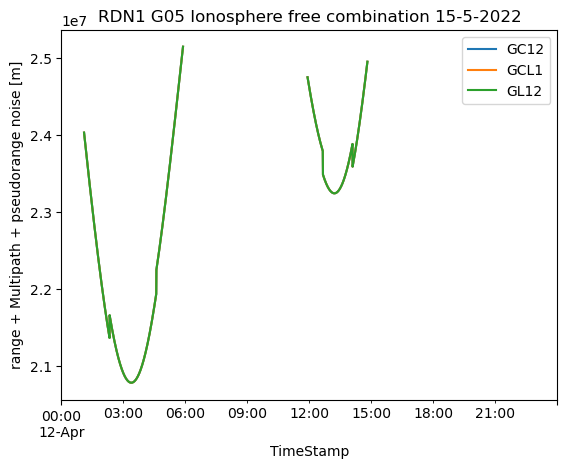

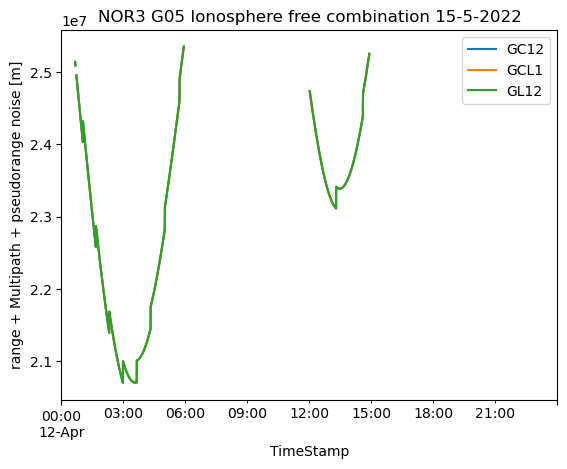

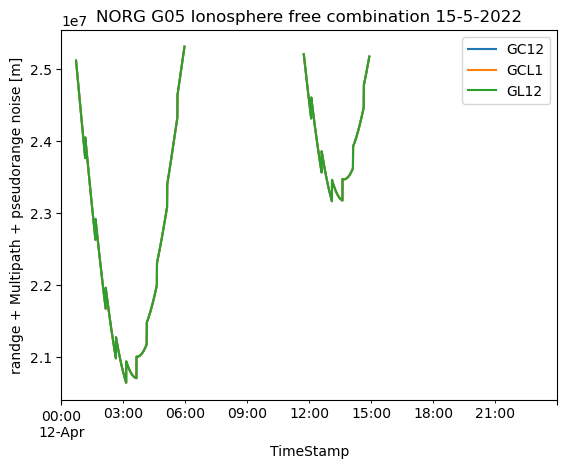

In [293]:
rnxUnstack(G_stacked_RDN1)['G05'].plot(ylabel='range + Multipath + pseudorange noise [m]', title='RDN1 G05 Ionosphere free combination 12-4-2022');
rnxUnstack(G_stacked_NOR3)['G05'].plot(ylabel='range + Multipath + pseudorange noise [m]', title='NOR3 G05 Ionosphere free combination 12-4-2022');
rnxUnstack(G_stacked_NORG)['G05'].plot(ylabel='randge + Multipath + pseudorange noise [m]', title='NORG G05 Ionosphere free combination 12-4-2022');
